---
> 「生まれ生まれ生まれ生まれて生の始めに暗く、死に死に死に死んで死の終わりに冥し」  
> 空海
---

回帰型ニューラルネットワーク(Recurent)は自然言語処理の分野で高い成果をあげた過去がある機械学習手法の一つ
- 現在では自然言語処理分野ではTransformerやその応用例が広く利用されている
- 現時点では、履歴を勘案できる軽量な手法として扱うとよいであろう

連続的な情報の利用
- 従来のニューラルネットワークは入力と出力データは互いに独立であるという考え
  - ポアソン過程的発想（独立同分布的な発想）
- RNNは過去の影響を内部状態として保持し、出力データは入力と内部状態で決定するべきという考え
  - ステートマシーン的発想

RNNは以前に計算された情報を覚えるための記憶力を備えているといえる
- 理論的には長い期間に渡る記憶を利用できるが、工夫なく実際に実装すると2,3ステップくらい前の情報しか記憶に含むことができない
- この工夫は後で紹介するとして、その構造について触れる

# RNN

## RNNの構造

PyTorchで単純な構造をもつ再帰型ニューラルネットワーク(Recurrent Neural Network:RNN)を構築する

ややこしいが、Reccurrent NNとRecursive NNがあり、訳語は回帰型ニューラルネットワークと再帰型ニューラルネットワークと使い分けるケースが多いが、一部で訳語の混乱も存在する

一般にRNNはRecurrentを指し、Recursive NNは、出力にさらに別のモデルの入力が繋がるようなネットワークを意味する

RNNの内部は次の図のようなフィードバック構造をもつ

- 例えば、過去5日分のデータを使う、5ワードからなる文章を扱うなどで5個前まで見るとすると、1層1データ・ワードで5層のニューラルネットワークとしてみることができ、これをunfold、展開するという
- $x_t$は$t$ステップ目の入力、$s_t$は$t$ステップ時の隠れ要素でこの隠れ要素が記憶に相当する
- 入力に対する変換$U$、出力に対する変換$V$、それ以外のRNNの核心にあたるループに含まれる変換$W$というそれぞれの変換があるとき、
$$o_t=softmax(Vs_t)=softmax(Vf(Ux_t, Ws_{t-1}))$$
となる
  - unfoldしても$V, W, U$は唯一であり、$s_{t-1}$つまり一つ前の$s$を利用する点に注目する
  - $f$としてtanhやReLUなど比較的勾配消失に強い活性化関数が利用される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnnature.jpeg" width="400">

なお、RNNを利用する際に次の2つの手法がある
- **最終出力(最も新しい段)のみ利用する手法**  
例えば図が全ての展開であるならば、$o_{t+1}$のみ利用する手法

- **全出力を利用する手法**  
つまり、同様に$o_{t-1}$、$o_t$、$o_{t+1}$の全てを利用する手法

## RNNの応用例

RNNが得意とする応用例は次の通りであるが、**自然言語処理などにおいては、Transformerの登場により状況は大きく変化している**

- 言語モデルと文章生成
  - 言語モデルとして、連続した単語の羅列において、直前の単語を利用して次の単語の出現確率予測が可能であり、機械翻訳などに活用されてきた経緯がある
  - 次の単語を予測できることから、出力の確率をサンプリングつまり、入力とすることで、さらに次の新しい単語をといった具合に全体で文章を生成するGenerativeなモデルが獲得できる
  - この学習においては、$O_t = x_{t+1}$として訓練する
    
- 機械翻訳
  - 言語モデルと似ているが、出力列は完全な入力列を読み込んだ後に処理を開始する点が異なる

- スピーチ認識
  - 音波としての連続的音響信号を入力として連続的な音声セグメント(音素)を確率予測する

- 画像の概要生成
  - CNNとRNNを用いることで、ラベルなし画像の概要生成(写真からその写真を説明する単語要素を生成する)が可能となる

その他時系列情報を有するデータに広く応用可能であり、音声データ、動画解析、株価予測、機器の異常検出などにも応用されている

## RNNの学習

通常のNNと同様に学習させるが、RNNのパラメーターはunfoldされたネットワーク上の全ステップで利用されるため、ステップ毎の勾配計算の全てに同じ値を用い、過去に戻って勾配を足し合わせる必要がある
- Backpropagation Through Time (BPTT)と呼び、長いステップ、遠い過去程学習させるのが困難となる
- この問題を解決する手法としてLSTMなどが提案されている

RNNにノイズを付与したサイン曲線を学習させ、曲線がどのように推移するかを予測させるとともに、その予測結果に基づいて曲線を描画させる

- 学習により、主成分であるサイン曲線を学習し、ノイズのない滑らかな曲線を描くようになると予見される

sinの式を教えずに、sinのブラフ(に類似した曲線)を得ることを目標とする

### 訓練用データの作成

サイン曲線に正規分布に基づく乱数でノイズを加えてRNNに用いる訓練用のデータを作成する

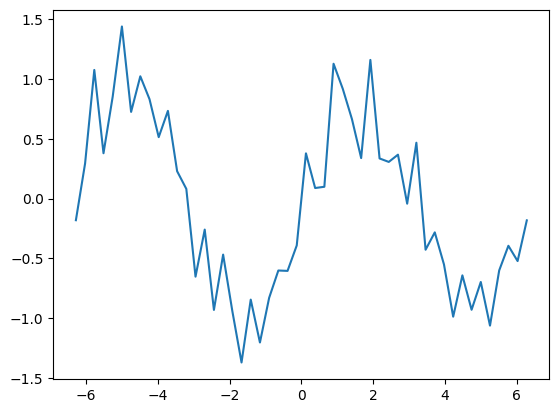

In [ ]:
cuda = "cuda:0"
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_y = np.sin(sin_x)+np.random.normal(0, 0.3, len(sin_x))  # sin関数に乱数でノイズを加える
plt.plot(sin_x, sin_y)

ノイズ付きサイン曲線の一部を入力とし、次の値を予測するようにRNNを訓練する

### データの前処理
入力、正解データをRNNに適した形に整形する
- 時系列データから次の値を予測できるように、時系列データを入力とし、正解をその時系列データの次の値とする

`input_data = np.zeros((n_sample, n_time, 1))`は入力構造そのものである
- unfoldしたとき、段数がn_time
- 今回の入力はサイングラフのyの値一つのみ
- データを次々と入力するが、それがn_sample回
- 以上を表現すると、3次元配列で、`(n_sample, n_time, 1)`となる

同様に`correct_data = np.zeros((n_sample, 1))`は、最後の(最新の)段の出力に対する正解データを示す

次のforループで実際にデータを投入している
- pythonマジックがあり慣れないと？かもしれない
- `correct_data[i]`は要素一つなのに、`sin_y[i+n_time:i+n_time+1]`って要素2個じゃないの？とか他の言語を触っている人は考えてしまう、分かっていても考えてしまう
  - pythonフリークは、何がわからないのかさっぱりわからないであろう
- sin_y[0]はnumpyのfloatの値、sin_y[0:1]はnumpy arrayを返して0から1個分の配列なので、要素数が1となる
  - これを0から1までの配列と思うとハマる
  - 違いは、arrayかどうか
- このreshapeの使い方もこれまで通りで、独特であるがあるあるなので抑えておくこと
  - modelに食べさせるテンソルは3次元で、これがないと2次元となり、`y = model(x)`などでエラーになる
  - 動いているコードの**データの型**をよく見ておくこと

次に、TensorDatasetでデータセットを作成

最後にDataLoaderでミニバッチを構成



In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
n_time = 10  # 時系列の数
n_sample = len(sin_x)-n_time  # サンプル数、len(sin_x)が50であるため、40となる
input_data = np.zeros((n_sample, n_time, 1))  # 入力で空の配列を生成
correct_data = np.zeros((n_sample, 1))  # 正解
for i in range(n_sample):
  input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
  correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 正解は入力よりも一つ後のみ含む配列
#   ここは、correct_data[i] = [sin_y[i+n_time]] このように記述しても同じです
input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### モデルの構築

まず、RNNのパラメータは以下の通り

| | |
|:--|:--|
|input_size|入力の特徴量数x|
|hidden_size|隠れ状態の特徴量h|
|num_layers(=1)|スタック数、RNNを複数重ね合わせる構造|
|nonlinearity(=tanh)|活性化関数(`relu`/`tanh`)'|
|bias(=True)|バイアス重み利用切替(ON=True)|
|batch_first(=False)|入出力テンソルを(`batch`,`seq`,`feature`)で提供|
|dropout(=False)|最終層以外にDropout層を導入|
|bidirectional(=False)|双方向RNNとする|

- 入力(input, $h_0$)は次の通り

| | |
|:--|:--|
|input|入力シーケンスの特徴を含むテンソル<br>省略するがパックしてより詳細な情報を入力できる|
|$h_0$|内部状態初期値で省略すると0|

- 出力(output, $h_n$)は次の通り

| | |
|:--|:--|
|output|最終層からの出力特徴量($h_t$)を$t$ごとに含むテンソル|
|$h_n$|隠れ状態のテンソル|

- 入力はパックでき、output.view(seq_len, batch, num_directions, hidden_size)であるが、パックされた場合も同様の次元をもつ
- 出力は$h_n$.view(num_layers, num_directions, batch, hidden_size)として分離できる


例えば、これまで通りの記述でいけば、シンプルには次のような記述でよい
```
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)  # 全結合層
    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(device)
        y_rnn, hidden = self.rnn(x, None) # ここを工夫すればinit_hiddenは不要
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y
model = RNN().to(device)
```

#### さて、PyTorchの癖を学ぼうか

`nn.Module`を継承したクラスとしてモデルを構築する
- 特に面倒なところはPyTorchではnn.RNNとして準備されているので、これを利用するだけである
  - 中身の詳細がわからなくても、どういうもので、どういうときに使うかさえ知っていれば設計できる
  - PyTorchにはRNNというユニット全体を扱うクラス以外に、RNNCellというユニット単体を扱うクラスがあり、RNNCellを組み合わせることで設計することもできる
- `batch_first`をTrueにすると`(seq_len, batch, input_size)`と指定されている入力テンソルの型を`(batch, seq_len, input_size)`にできる
  - 初期はDataLoaderと同じ並びであったのが、互換性を維持して新規にbatch_firstを導入したという経緯であろう

GPUを利用するため、入力のxはGPUへ、検証の際の正解データyもGPUに送る必要がある
- 学習の入力は全てGPUに送る
  - 余計なものも.to(device)で送ることができるが、無意味にGPUメモリを浪費するだけである
- `RNN().to('cuda')`と、最低でも書いておけば、必要なデータがGPUにない場合、エラーが表示されるため、エラー個所を順番に解決すればよい

RNNの肝は、`y_rnn, hidden = self.rnn(x, None)`である
- 実はこれだけでよく、Noneと書くと、ゼロ初期化される
  - init_hiddenも実は不要
- Noneを具体的に書くと次の通り
```
torch.zeros(self.n_layers, batch_size, self.hidden_size)
```
- ここでは、さらに`init_hidden`と関数化している
  - init_hiddenを関数化しる場合、その戻り値はGPU内部に存在しないといけないので、`to(device)`が必要


#### さて、pythonの癖を学ぼうか

およそ疑問に思うのは次の点であろう
- なぜ n_layersとhidden_sizeだけselfなのか？
  - まずselfを付けるということは、オブジェクト変数であることを理解する(クラス変数というのもある)
  - インスタンス化されるたびにメモリに領域が獲得され、インスタンス化毎に違う値をとることができる
  - 呼び出された`def __init__`内であれば、呼び出されたスコープ(この関数内)で使って捨てられてもよいのでselfは要らない
  - ところが、`n_layers`と`hidden_size`は`init_hidden`でも使われており、`init_hidden`を呼び出したときには既に`__init__`のスコープ外でアクセスできないのでselfを付ける必要がある
  - これも、忘れたところでエラーになるのでそれほど問題ではない(であるなら、言語仕様で自動化もできたのでは？と言いたい気持ちはわかる)

- では、y_rnn, hidden, inithはselfじゃなくてよいのか？
  - forward中だけで毎回メモリから確保されても特に困らない、こだわりのスピード狂ならば、selfにしてもよい

- `y_rnn[:, -1, :]`はなに？
  - まず、訓練時のy_rnnは、torch.Size([8, 10, 64])という型になる
  - テストのときは、torch.Size([1, 10, 64])という型になる
    - これはミニバッチなので当然
  - 次に、-1は最後のデータ、-2は最後から2つ目のデータの意味で、:は、全ての意味
  - もし、この`[:, -1, :]`そのものがわからないという場合は、過去の課題を再確認するとよい


#### さて、RNNのハマり所を学ぼうか

一般的なRNNを記述する上では特に疑問はないと思うが、次の点は注意した方が良い

- `n_time`回繰り返して利用するはずなのに、その指定がどこにもないけど、大丈夫か？
  - 「入力xのサイズをみて判別できるが、その前にトポロジやパラメタの数が確定しているのでダメでしょう」というごもっともそうな意見
  - このごもっともそうな意見を聞いて「そうじゃん」と思ったら不幸かも
  - 疑問に思った人は、よく考えて欲しい、「すべての層で同じ重み、バイアスを利用する」ということを
    - つまり、トポロジは確定でき、入力xに従って「計算上」使いまわすだけなのだ
    - 入力xのサイズでパラメタ数が変わるわけではない
    - さらに言えば、Define-by-Runなので、使いまわしてforwardさえ計算できれば後は自動

- `RNN(1, 64, 1, 1)`ってなに？input_sizeはn_timeが10だから`RNN(10, 64, 1, 1)`じゃないの？
  - 注意してマニュアルを見ると、Inputsは入力シーケンスの特徴を含むテンソルとあり配列ではない
  - バッチサイズを各回で変更できるため、そのための複数指定
    - 普通は1となることに注意する
  - この1個のテンソルに、バッチサイズ $\times$ 入力列 $\times$ 次元の値が格納されている、つまり1個で十分な情報がある
  - これはFCなども同じだが、パラメタが増えて複雑になると、途端にわからなくなりがちなので注意


でよいが、次のような記述スタイルになると、**本当に理解しているか**が確認できるであろう

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers):
    super(RNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)  # 全結合層
  def forward(self, x):
    batch_size = x.size(0)
    x = x.to(device)
    inith = self.init_hidden(batch_size)
    y_rnn, hidden = self.rnn(x, inith) # ここを工夫すればinit_hiddenは不要
    y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
    return y
  def init_hidden(self, batch_size):
    return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
model = RNN(1, 64, 1, 1).to(device)
print(model)

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### 学習
モデルを訓練する

DataLoaderよりミニバッチを取り出しつつ訓練と評価を行う

ここでは、途中の訓練状況を見ることで、テーラー展開のように**徐々に(というか突然気が付いたように)サイン関数曲線に近づく**ところも観察する

Epoch: 9 Loss_Train: 0.238596673309803


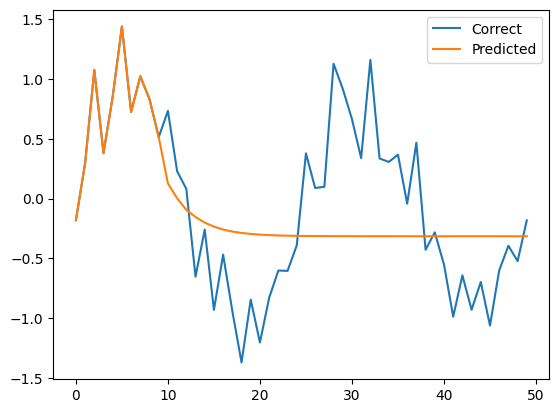

Epoch: 19 Loss_Train: 0.181535005569458


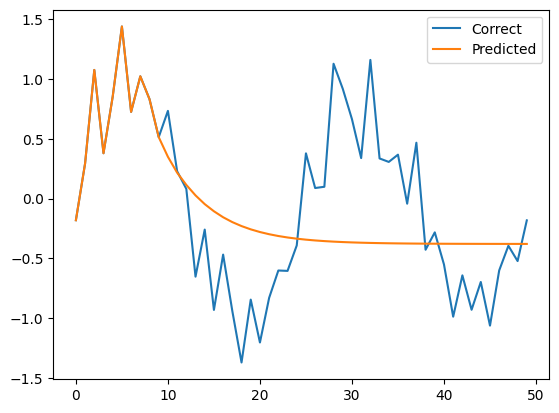

Epoch: 29 Loss_Train: 0.16175987124443053


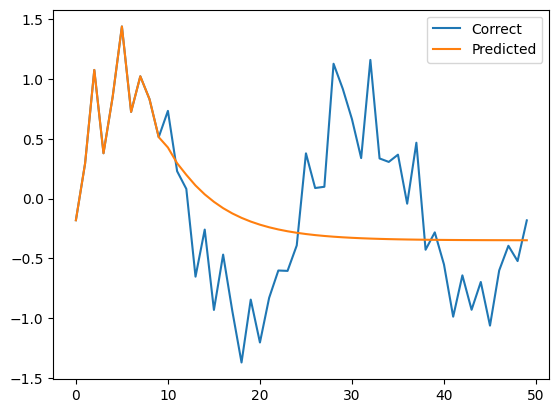

Epoch: 39 Loss_Train: 0.14988896399736404


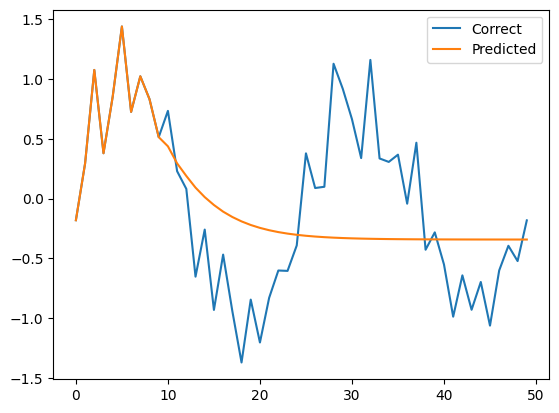

Epoch: 49 Loss_Train: 0.13758897483348848


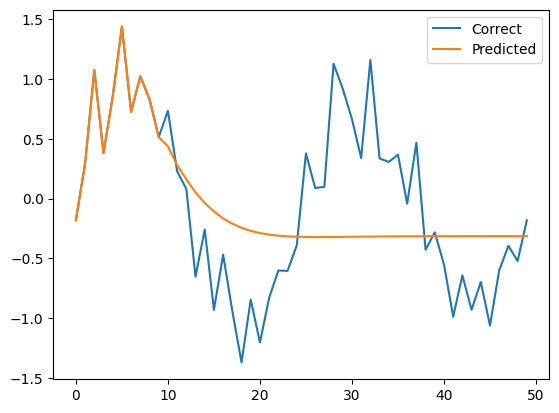

Epoch: 59 Loss_Train: 0.12731565088033675


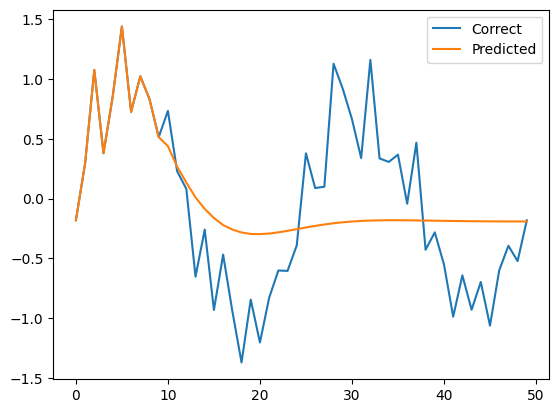

Epoch: 69 Loss_Train: 0.11261748224496841


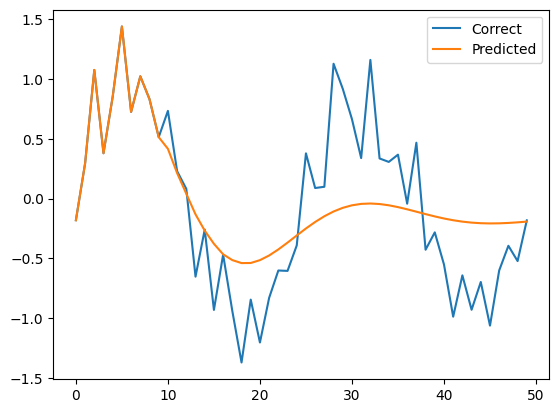

Epoch: 79 Loss_Train: 0.10399200022220612


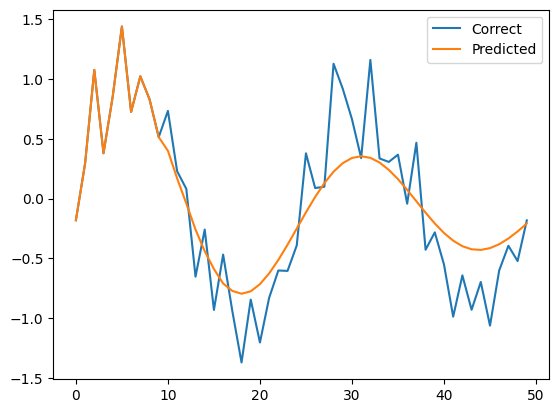

Epoch: 89 Loss_Train: 0.09824269488453866


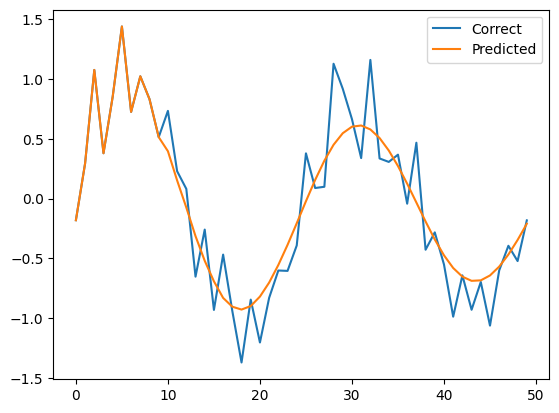

Epoch: 99 Loss_Train: 0.09470836073160172


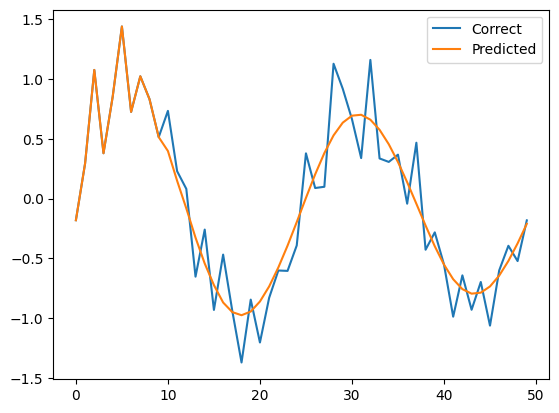

Epoch: 109 Loss_Train: 0.09329548478126526


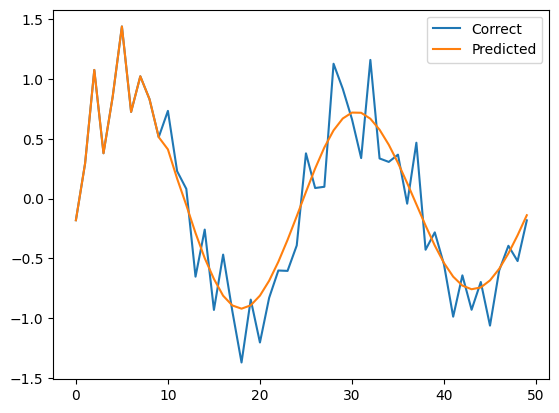

Epoch: 119 Loss_Train: 0.0888146586716175


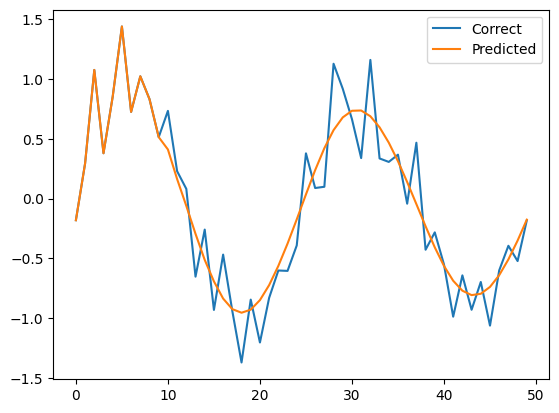

Epoch: 129 Loss_Train: 0.08721897304058075


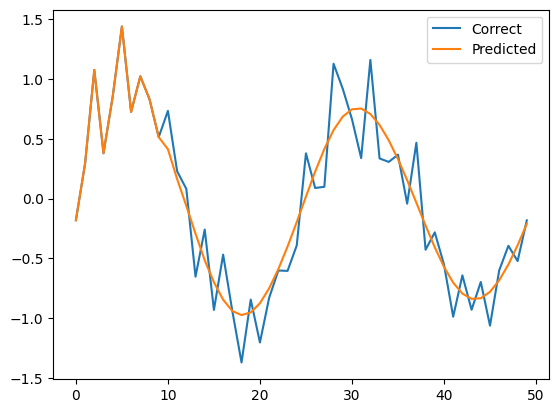

Epoch: 139 Loss_Train: 0.08533424995839596


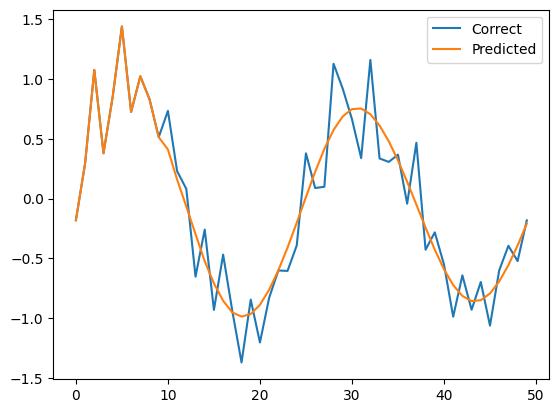

Epoch: 149 Loss_Train: 0.08340487033128738


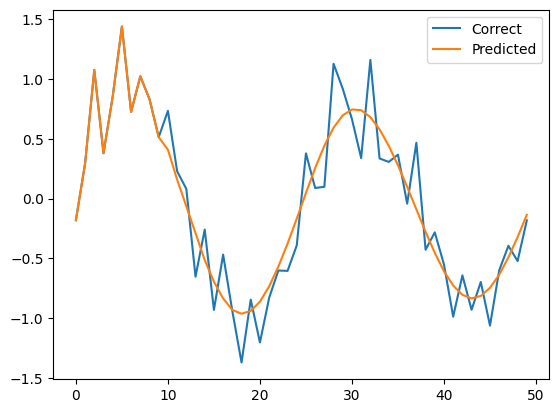

Epoch: 159 Loss_Train: 0.08036786615848542


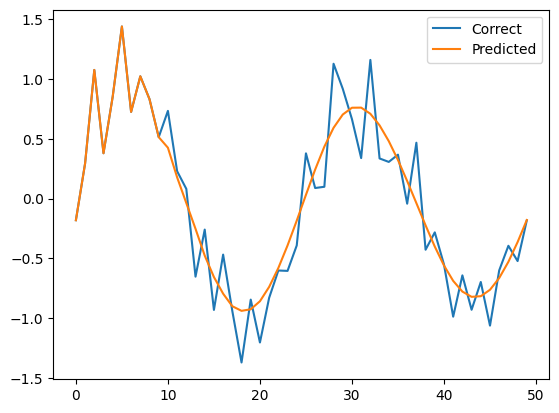

Epoch: 169 Loss_Train: 0.08095169365406037


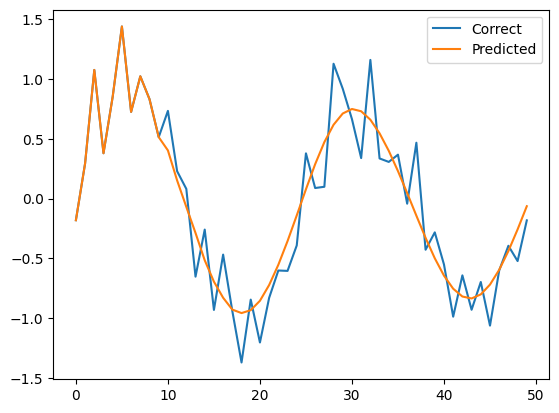

Epoch: 179 Loss_Train: 0.07967432066798211


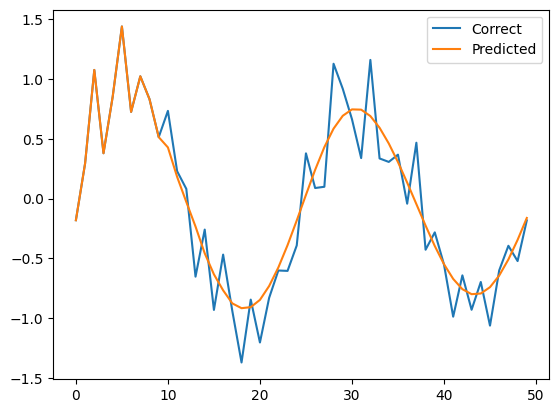

Epoch: 189 Loss_Train: 0.07836147099733352


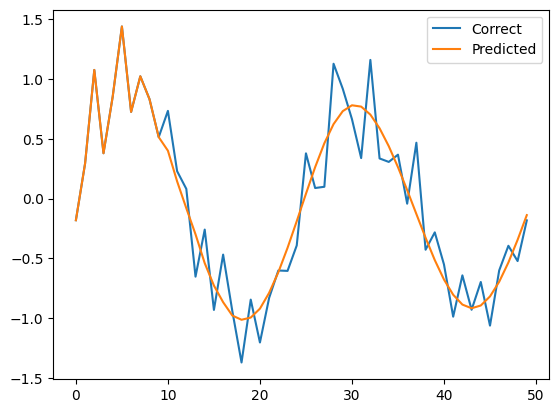

Epoch: 199 Loss_Train: 0.07549143061041833


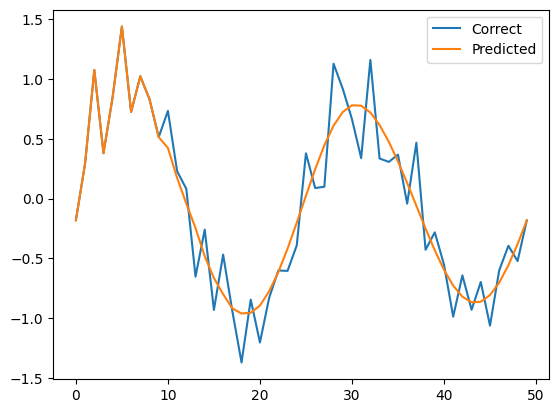

In [ ]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 学習率は0.01
# 損失のログ
record_loss_train = []
# 学習
for i in range(200):
  model.train()  # 訓練モード
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
    y = model(x)
    loss = loss_fnc(y, t.to(device))
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)
  if (i+1)%10 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train)
    predicted = list(input_data[0].reshape(-1)) # 最初の入力
    model.eval()
    with torch.no_grad():
      for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:])  # 直近の時系列を取り出す
        x = x.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
        y = model(x)
        predicted.append(y[0].item())  # 予測結果をpredictedに追加する
    plt.plot(range(len(sin_y)), sin_y, label="Correct")
    plt.plot(range(len(predicted)), predicted, label="Predicted")
    plt.legend()
    plt.show()

### 誤差の推移

訓練データ、テストデータで誤差の推移をグラフに表示する  

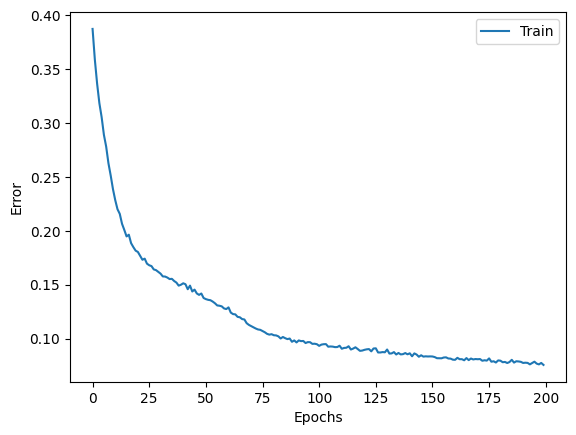

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

乱数を固定していないので見えるか見えないかは運かもしれないが、スパイクや振動が見られる場合がある
- RNNではそのようなグラフになることが少なくない
- サイングラフならば、その全体の形がいきわたることが何回か体験する必要があり、シンプルなサインなので、一度かみ合えば急激に減衰する
- エポックを増やして、過学習にしてみるなど、実験してみよう

# LSTM

## LSTMの構造

LSTM(Long short-term memory:長・短期記憶)はRNNの拡張として1990年代半ばに提案され，1997年に代表的な論文が出版された時系列データ(sequential data)に対するモデルである

RNNは前にモデルに取り入れた情報を、次の予測に使う回帰モデルであり、その中心に全結合網を利用したが、LSTMは専用のLSTM層を用いることで、様々なRNNにおける問題に対応する

- Backpropagation Through Time(BPTT)による長いステップ、遠い過去の学習が困難であった
  - RNNのWに全過去の履歴を画一的に学習させるのは困難
  - 通常のRNNでも数十ステップの短期依存(short-term dependencies)には対応できるが、1000ステップといった長系列に依存する場合は学習できなかった

- RNNでは勾配消失問題に加えて勾配爆発問題も深刻であった
  - 大きくても小さくても問題となり、tanhを使って和らげているとはいえ、ステップ数が大きいと問題が発生しやすかった
  - LSTMではセル状態は加算主体の経路(線形に近い経路)で伝搬するため、純粋な RNN より勾配消失が起こりにくい

LSTMも様々拡張されており、いくつかの有用なバージョンが存在する
- PyTorchでは、比較的新しい構造が実装されており、この構造について概説する


## LSTMの構造と特徴

以下の特徴的な構造をもつ
- **記憶セル**の導入による長期の記憶保持
- **ゲート**と呼ぶ情報の流れを調整する機構の導入
  - ゲートが記憶セルの内容を**忘れるか忘れないか**を判断し、必要な情報のみ次の段に引き継ぐ



### 何がRNNと違うのか

RNNは鎖の形状をもち、モジュールの中は単一のニューラルネット層である tanh 層を持つ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-new1.png" width=700>

一方で、LSTMは、単一のニューラルネットワーク層ではなく、相互作用する4つの層を持つ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-new2.png" width=700>

ここで、図の記号について次のように定義されている
- 黄色の□はニューラルネットワークである
- 〇はベクトル間の演算を行う
- →はベクトルの移動を意味する
- →の融合はベクトルの結合を意味する
- →の分岐はベクトルのコピーを意味する



### LSTMの構造

LSTMの基本は、上部を流れる各セルの状態を意味するCの連結部分であり、この基本部分に各セルが様々な操作、例えば情報を追加・削除する構造をもつ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-newcell.png" width=700>

この操作はゲートと呼ばれる「情報を通す割合を制御する」構造により行われ、シグモイドニューラルネットワーク層の出力との乗算により構成される
- シグモイド層の出力は0から1まで値をとり、その乗算を得ることから、0は何も通さない、1は全て通すという意味になる
- LSTMはこのようなゲートを3つもつ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-newgate.png" width=100>

### LSTMの動作

LSTMは次のステップで動作するとみなすことができる

#### 最初のステップとして、セル状態から捨てる情報を判定する

- この判定は**忘却ゲート層**と呼ばれるシグモイド層によって行われる
ます。$h_{t-1}$と$x_t$をみてセル状態$C_{t-1}$と同じサイズの0から1の値を持つベクトルを生成し、掛け算を求めることで行う
- 古い状態に生成された$f_t$を掛け値を小さく(より発火しない状態に)する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-newforget.png" width=700>

#### 次のステップで、セル状態で加えるべき、さらには、セル状態で保存するべき新たな情報を生成する

これに関係する部分は次の2つの値を利用する

- **入力ゲート層**と呼ばれるシグモイド層は、どの値を更新するかを判定する
- **tanh 層**はセル状態に加えられる新たな候補値のベクトルを作成する

これら2つを掛け合わせる、つまり$i_t \times \tilde{C}_t$を加えることで更新するべき情報を生成、セル状態Cに可算することで、古いセル状態$C_{t-1}$を$C_t$へ更新する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm-newlearn.png" width=700>

#### 最後のステップで、出力するべき値を確定される

- 出力するべき値は、セル状態$h_{t-1}$から生成され、まずシグモイド層によりセル状態のどの部分を出力するかが決定される

- 次に、判定された部分のみ出力するため、セル状態$C_t$に$tanh$を適用して-1から1の値とし、この値とシグモイド・ゲートの出力を掛る


### LSTMにおける記憶セル

少し見方を変える

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmfig.png" width=500>

図において、先ほどと同様に$\oplus$は要素同士の和、$\otimes$は要素同士の積、$\sigma$はシグモイド関数を有するニューラルネットワーク層、$tanh$は$tanh$を有するニューラルワーク層、矢印の結合は連結、分岐はコピーを表す

全体の構造として、記憶セルから忘却ゲートとの積、入力ゲートとの和を経由して記憶セルに戻るパスが見える(右上の逆三角形のパス)

- このパスは、2つのセル間で構築される
- このパスに対して忘却ゲートは積を算出するため、継承重みが制御される
- このパスに対する入力、つまり新しい情報の追加も入力ゲートにより制御される
- 記憶セルの内容が出力に影響する割合も出力ゲートにより制御される

と見直すことができる

つまり、記憶セルに対する忘却、入力、出力がそれぞれ制御されていることになる

LSTMは比較的強力なモデルで、過去の履歴情報に基づく学習を行う際には利用を検討するべきモデルである


### LSTMの種類と比較

ここでは紹介しないが、LSTMには様々なバリエーションがある
- 唯一、GRUについては別途触れる

これらの違いについては、Greffら(https://arxiv.org/pdf/1503.04069)が、よく利用されるLSTMの比較を行い、ほぼ同等であるとしている
- その程度の違いであるが、違いはあるということ

## LSTMによる画像生成

画像を時系列データと捉えてLSTMにより画像を生成させる

- torchvision.datasetsにあるFashion-MNISTの画像データを用いて訓練し、画像の上半分をもとに画像の下半分を予測、生成させる

- Fashion-MNISTは6万枚のファッションアイテム画像にラベルをつけたたデータセットである

  - 今回、ラベルは利用しない
  - 白黒であるため、生成しやすい

画像の学習と生成のイメージは次の図を参照するとよい
- 画像は次のように構成され、行ごと入力される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnimg1.png" width=200>

訓練においては、上半分つまり14行(t=0からt=13)を利用して15行目(t=14)を教師として学習する
- 次の行は図で言う(t=1からt=14)を利用して16行目(t=15)を教師として学習する

推定も同様である

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnimg2.png" width=400>

なお、次のような疑問はごもっともである
- 入力14行だけを入力として、それぞれ別個に下の14行を学習させる、つまり14個の独立したモデルを持てばよいのではないか？
- そのとおりであるが、唯一のモデルで時系列もしくは、シリーズデータとして扱える点がRNNのメリットである
  - 実際にそのようなモデルを構築して比較してみるとよいであろう

まず、Fashion-MNISTをロードし、25枚の画像をランダムに選び出す


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


データ数: 60000


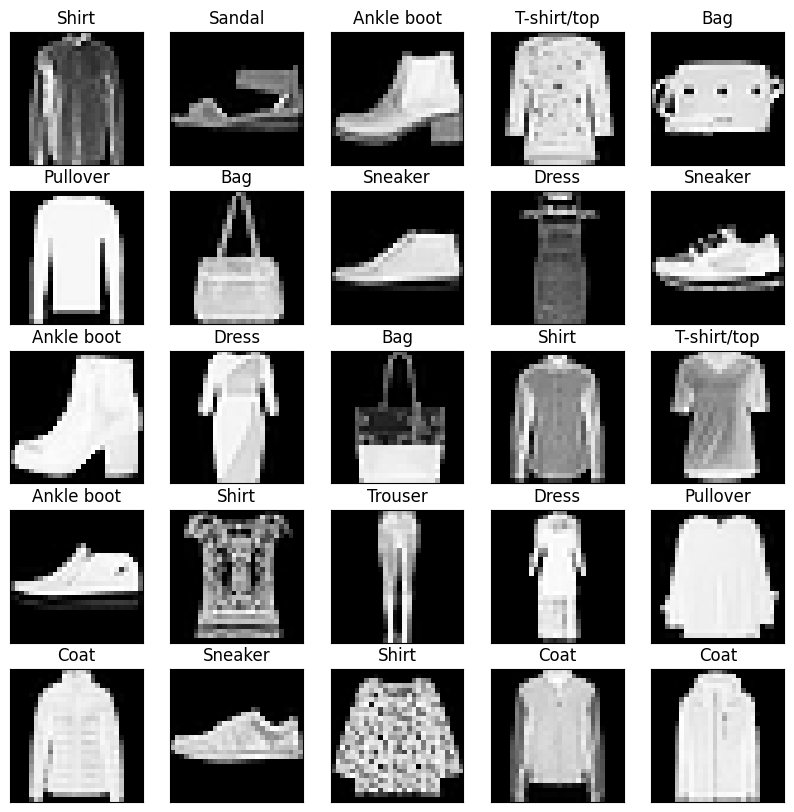

In [ ]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
fmnist_data = FashionMNIST(root="mydata",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("データ数:", len(fmnist_data))
n_image = 200  # バッチサイズ
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # イテレータ
images, labels = next(dataiter)  # 最初のバッチを取り出す
img_size = 28 # FasionMNISTの画像サイズは28x28である
plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

### データの前処理

画像データをPyTorchでの処理に適した形に整形する

- 画像の各行を時刻とみて時系列データに変換し、正解データは時系列における次の行とする

`train_imgs = train_imgs.reshape(-1, img_size, img_size)`について

- もともとは、`torch.Size([60000, 1, 28, 28])`というサイズであるが、これを`torch.Size([60000, 28, 28])`に変換している
- PyTorchではこのような処理はしばしば現れるため専用の`torch.squeeze`が用意されている
  - 例えば`train_imgs = train_imgs.squeeze()`としても同じ結果が得られる


In [ ]:
import torch
from torch.utils.data import DataLoader
n_time = 14  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 400  # 中間層のニューロン数 精度がそれほど必要なければ256でもよい。
n_out = img_size  # 出力層のニューロン数
n_sample_in_img = img_size-n_time  # 1枚の画像中のサンプル数
dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgsr, labels = next(dataiter)  # データを取り出す
train_imgs = train_imgsr.reshape(-1, img_size, img_size) # サイズを整える
n_sample = len(train_imgs) * n_sample_in_img  # サンプル数
input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
  for j in range(n_sample_in_img):
    sample_id = i*n_sample_in_img + j
    input_data[sample_id] = train_imgs[i, j:j+n_time]
    correct_data[sample_id] = train_imgs[i, j+n_time]
input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

/tmp/ipython-input-818349243.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  input_data[sample_id] = train_imgs[i, j:j+n_time]
/tmp/ipython-input-818349243.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  correct_data[sample_id] = train_imgs[i, j+n_time]


cuda:0


### テスト用のデータの作成

再びDataLoaderを用い、今度はtrain=Falseにして作る
- 今度はsqueezeを使ってみる

In [ ]:
n_disp = 10  # 生成し表示する画像の数
disp_data = FashionMNIST(root="mydata",
                        train=False,download=True,
                        transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgsr, labels = next(dataiter)  # データを取り出す
disp_imgs = disp_imgsr.squeeze().float()

### 画像生成用関数の定義

オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示する
- はじめに画像の上半分を履歴として次の行を生成し、さらにその行を含んで新たな履歴として次の行を生成する、という処理を繰り返す

In [ ]:
genimgflag = 0
def generate_images():
  # オリジナル画像の表示(最初の1回のみ)
  global genimgflag
  if genimgflag == 0:
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
      ax = plt.subplot(1, n_disp, i+1)
      plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)  # 軸を非表示に
      ax.get_yaxis().set_visible(False)
    plt.show()
    genimgflag = 1
  # 下半分を生成した画像の表示
  print("Generated:")
  model.eval()
  with torch.no_grad():
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
      for j in range(n_sample_in_img):
        x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
        x = x.to(device)  # GPU対応
        gen_imgs[i, j+n_time] = model(x)[0]
      ax = plt.subplot(1, n_disp, i+1)
      plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)  # 軸を非表示に
      ax.get_yaxis().set_visible(False)
    plt.show()

### モデルの構築
`nn.Module`モジュールを継承してクラスを構成

- LSTMは`nn.LSTM`を利用する
- 中身は RNNと変わらないので目新しさは特にない
- 今回はレイヤ数、つまりLSTMのスタック数は1とするため、指定は省略している
- このモデルは、statefullでも、statelessでも利用できるように構成されている

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class LSTMN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
    super(LSTMN, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)  # 全結合層
  def forward(self, x, hidden=None): # hidden = (h, c)
    y_lstm, hidden = self.lstm(x, hidden)  # hは次の時刻に渡される値、 cは記憶セル
    y = self.fc(y_lstm[:, -1, :])  # yは最後の時刻の出力, 実際にはhも同じ
    return y, hidden
model = LSTMN(n_in, n_mid, n_out).to(device)
print(model)

LSTMN(
  (lstm): LSTM(28, 400, batch_first=True)
  (fc): Linear(in_features=400, out_features=28, bias=True)
)


LSTMの隠れ層のネットワークは先ほどの図(再掲する)であるが、`y, (h, c) = LSNM(x, None)`と記述すると、記憶セルがc、$x_i$の入力がx、$y$全体がy、$y$の最後がhである。つまり、`h=y[:, -1, :]`となる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmfig.png" width=500>

これらのどの戻り値を使うべきかは、LSTMで解きたいタスクによる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmio.png" width=600>

その前の絵の情報(many)から次の行(one)を得たいので、 many to one モデルとなる
- 従って、LSTMの最後の隠れ層の出力hを使う
- hか、yの最後を使う

### 学習

モデルを訓練する

- **学習には40分程度必要となるので注意すること**

- `loss_fnc = nn.MSELoss()`は、各要素間の平均二乗誤差(L2ノルムの2乗)を算出する

- DataLoaderを用いてミニバッチを取り出して訓練と評価を行う

- 学習中はエポックごとに画像生成用関数generage_imagesにより生成画像が表示される

ここでは、stateless LSTMを用いており、
```
    x, t = x.to(device), t.to(device)  # GPU対応
    y = model(x)
```
と記述している

一方で、stateful LSTMは次のようになる
```
h, c = None, None

for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.to(device)
    if h is not None:
        h = h.detach()
        c = c.detach()
    y, (h, c) = model(x, (h, c))  # LSTM に状態を渡す
```
まず、ここで実装する例は、画像を対象としている

- 画像間で LSTM 状態（h, c）を保持しても意味がない（むしろ誤学習のリスクがある）ことから、stateless LSTM の方が妥当で、stateful LSTM にしても性能向上しない可能性がある
- その他、各バッチ内のサンプルがシャッフルされている（shuffle=True）場合は、順序性が崩れるため stateless が適切となる
  - statelessであれば、shuffle=Trueでよい
- バッチサイズが固定されていない場合は、h, c のサイズと不整合が生じて初期化される可能性がある

一方で、長期依存が効く典型的タスクでは、LSTMが意図した通りに機能するためには、stateful LSTMとする必要がある
- 論理的に連続した入力シーケンス、例えば、d0, d1, d2, d3の次に、d1, d2, d3, d4などが用いられ、各時間ステップが前後のステップと時間的・因果的に関連している
- ネットワークの内部の隠れた状態/セル状態がステップ間でリセットされずに時間経過と共に進化する構造である
- 音声認識（1文が数秒にわたる）や、言語モデル（文章全体に意味的整合性が必要）、時系列予測（気象データ・株価など）で利用される

sateful LSTMでは、

- model(x) の呼び出し前に LSTM の状態を初期化していないが、PyTorch の nn.LSTM は、デフォルトで各入力ごとに hidden state / cell state を初期化（ゼロ）されるため、明示的に初期状態（h, c）を渡す必要がある
- つまり、"stateful LSTM"（＝系列間で状態を保持し続ける）とするためには、明示的に実装する必要がある
- hやcを渡す場合、明示的に detach() してグラフ切断を行い（累積勾配防止）、次回の model(x) に渡す必要がある
ここでは、stateless LSTMを扱い、この後にstateful LSTMを扱う

ここでは、20エポックだけの計算としている
- 時間とクレジットに余裕がある人は40エポック、60エポックと実行してみるとよい

Epoch: 1 / 20  Loss_Train: 0.016950560388066308
Original:


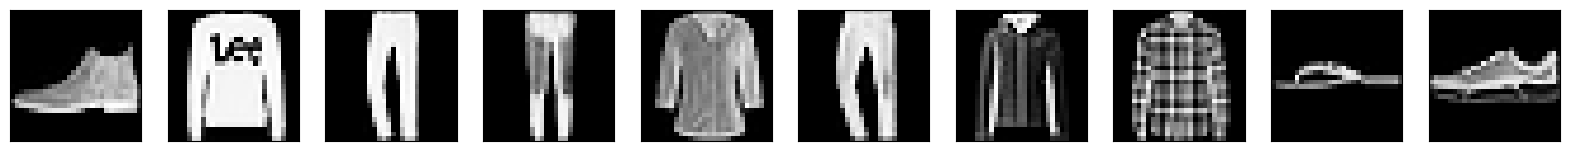

Generated:


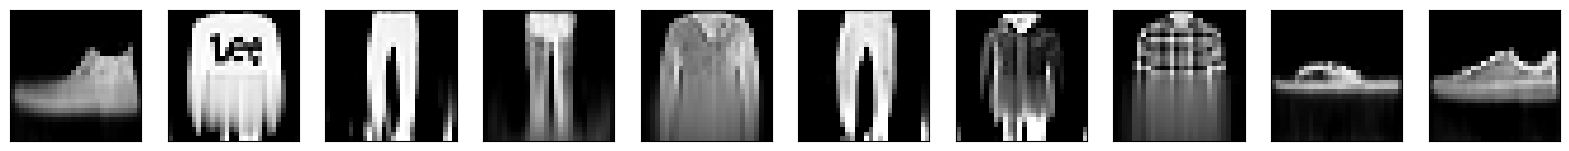

Epoch: 2 / 20  Loss_Train: 0.013165138011865526
Generated:


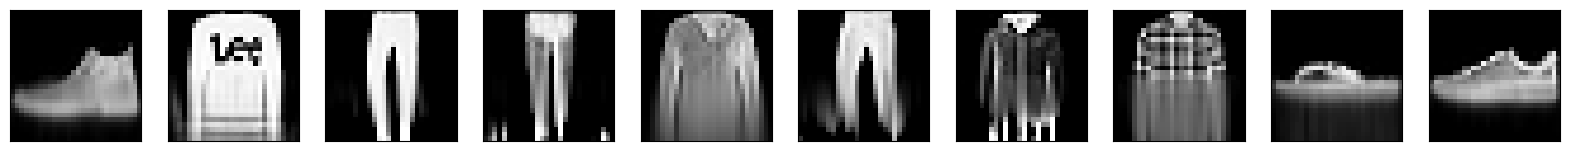

Epoch: 3 / 20  Loss_Train: 0.012067539173327518
Generated:


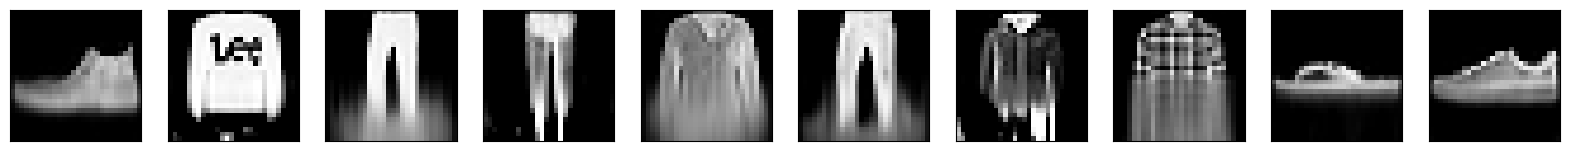

Epoch: 4 / 20  Loss_Train: 0.011457295112882866
Generated:


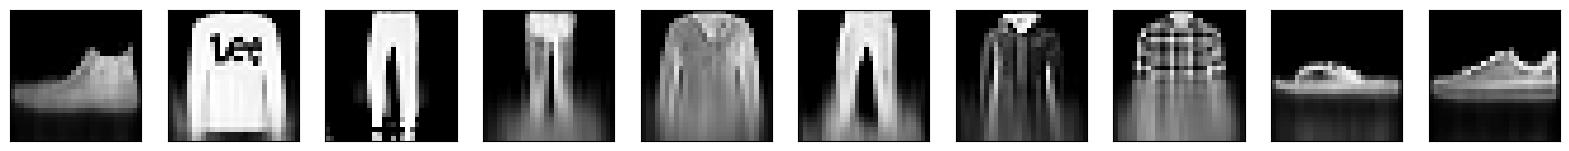

Epoch: 5 / 20  Loss_Train: 0.011008526636626723
Generated:


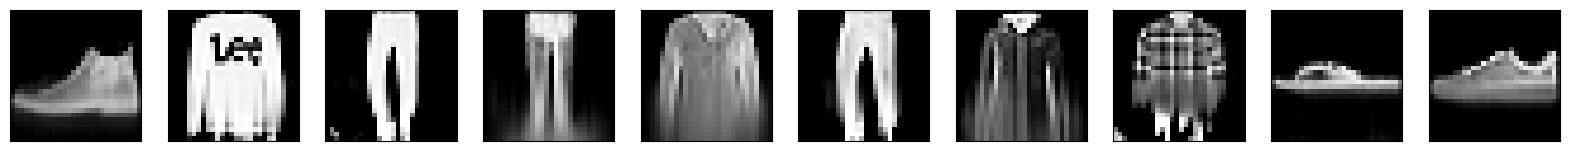

Epoch: 6 / 20  Loss_Train: 0.010657844076842142
Generated:


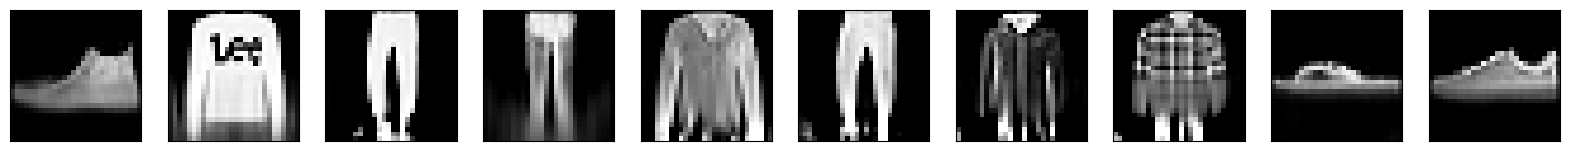

Epoch: 7 / 20  Loss_Train: 0.010355260399467226
Generated:


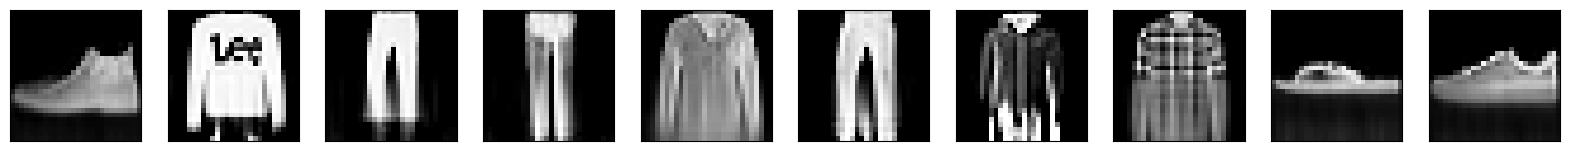

Epoch: 8 / 20  Loss_Train: 0.010093305225105329
Generated:


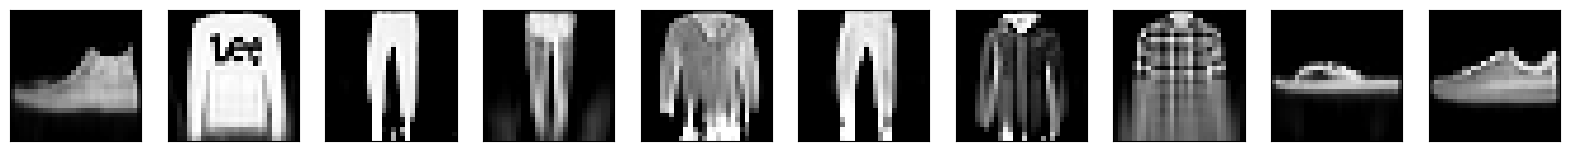

Epoch: 9 / 20  Loss_Train: 0.009860628229880522
Generated:


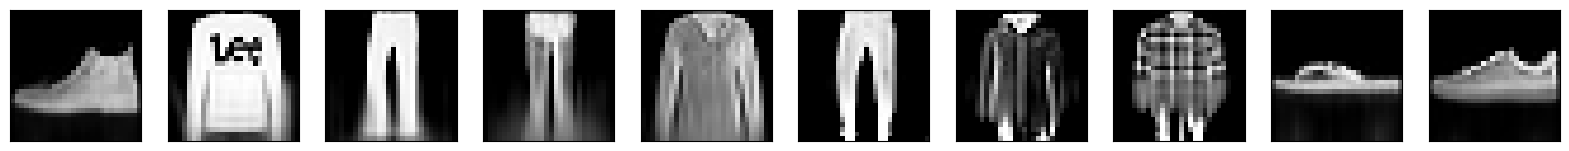

Epoch: 10 / 20  Loss_Train: 0.009655136335910764
Generated:


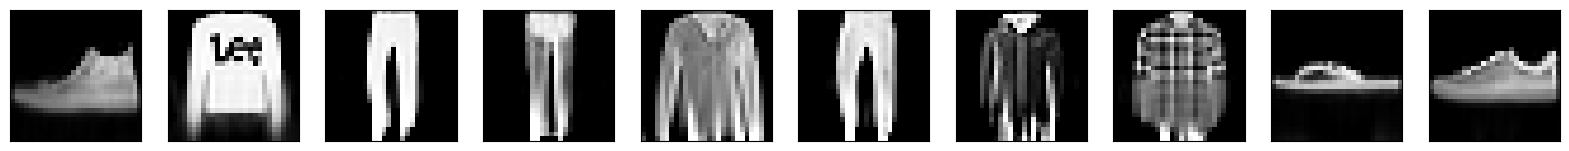

Epoch: 11 / 20  Loss_Train: 0.009468349221805469
Generated:


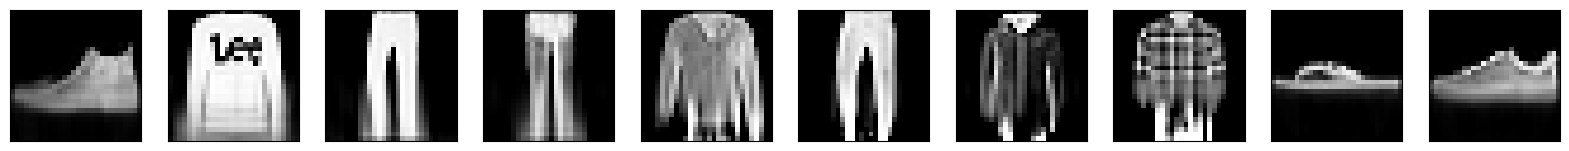

Epoch: 12 / 20  Loss_Train: 0.009300868521947836
Generated:


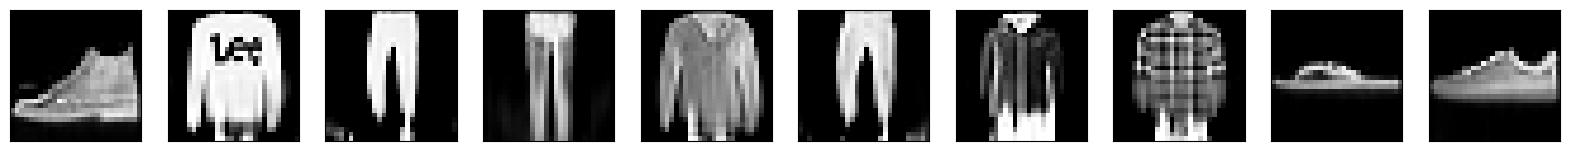

Epoch: 13 / 20  Loss_Train: 0.00913487447182498
Generated:


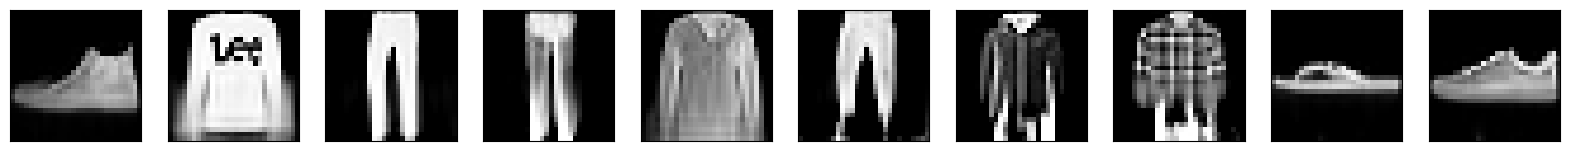

Epoch: 14 / 20  Loss_Train: 0.008987018388898798
Generated:


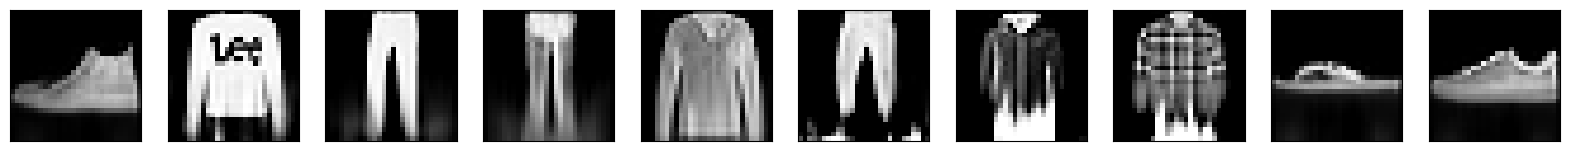

Epoch: 15 / 20  Loss_Train: 0.008845057172589226
Generated:


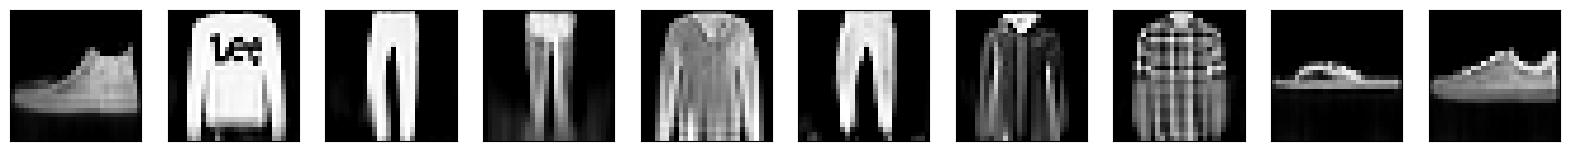

Epoch: 16 / 20  Loss_Train: 0.008727617895932512
Generated:


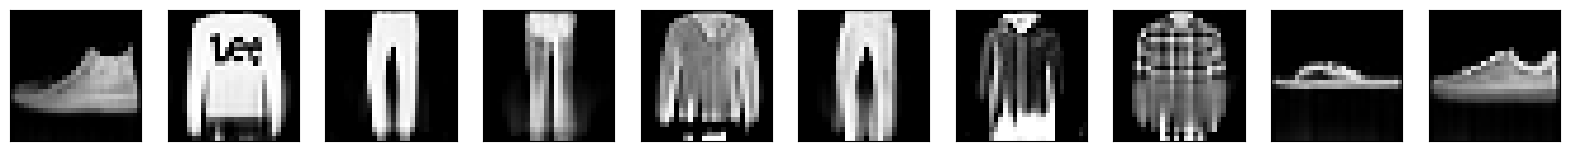

Epoch: 17 / 20  Loss_Train: 0.008610077467611513
Generated:


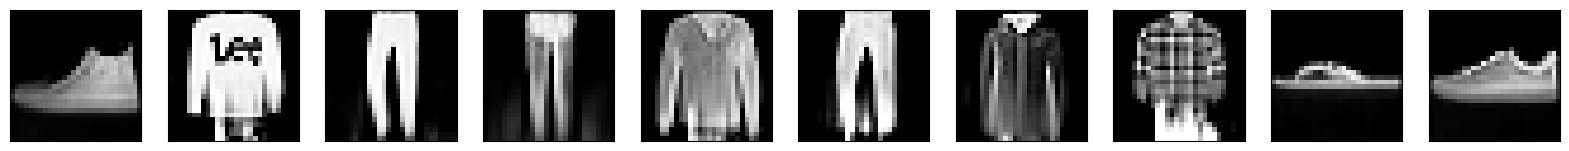

Epoch: 18 / 20  Loss_Train: 0.008489001256958815
Generated:


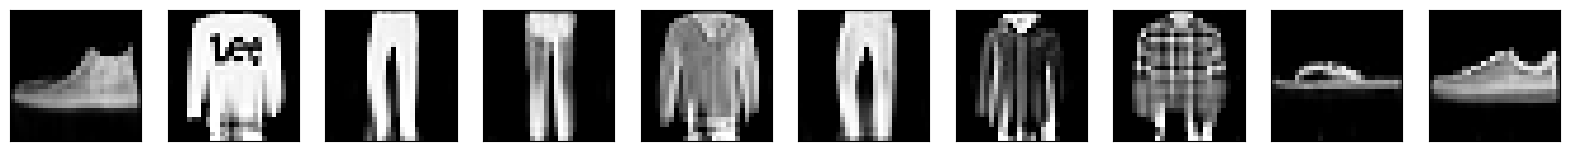

Epoch: 19 / 20  Loss_Train: 0.008389725153234112
Generated:


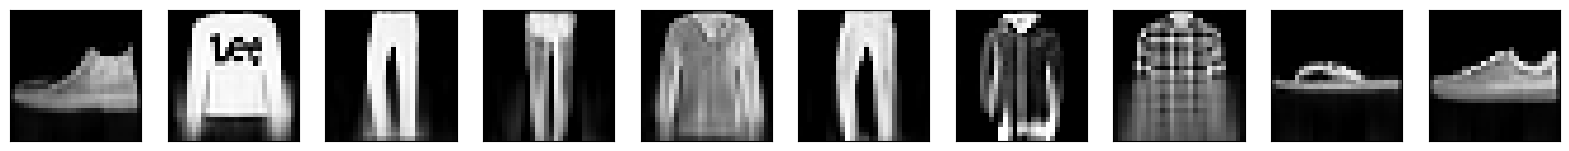

Epoch: 20 / 20  Loss_Train: 0.008284484066918285
Generated:


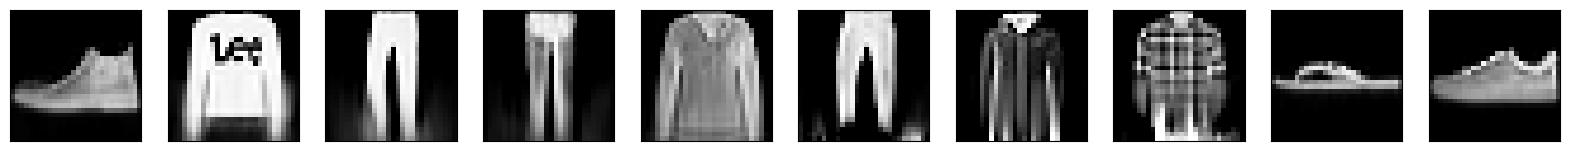

In [ ]:
num_epoch = 20
from torch import optim
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 学習率は0.01
# 損失のログ
record_loss_train = []
# 学習
for i in range(num_epoch):  # 40エポック学習 待ち遠しい場合は30エポックなどでも大丈夫
  model.train()  # 訓練モード
  loss_train = 0
  # Initialize h and c with tensors of the correct shape and device for the current batch
  for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.to(device)
    y,_ = model(x)  # LSTM に状態を渡す
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)
  print("Epoch:", i+1, "/", num_epoch, " Loss_Train:", loss_train)
  generate_images()

### 誤差の推移の確認

誤差の推移をグラフにより確認する

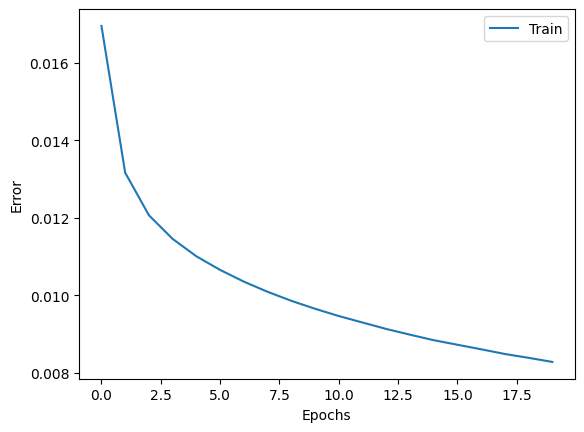

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

なお、ノード数が256の場合と400の場合では、次のような差がある
- 256ノードの時

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm256.png" width=400>

- 400ノードの時

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm400.png" width=400>

y軸の差に注目、30エポックでは400ノードの方が精度がよく、さらに向上できる見込みがある(学習不足=underfittingともいえる状態)
- 1エポックあたりの所要時間は1割ほど増えている

## LSTMの記憶能力について

### 入力のシーケンス長（ウィンドウサイズ）の意味は何か？

LSTMは名前の通り長期記憶が得意とされているが、なぜ、シーケンス長を定めないといけないのか？
- つまり、シーケンス長が長いほうが、長期記憶がよくなるのではないか？
- ということは、結局シーケンス長が長くないと意味がないのであれば、LSTMである必要はないのではないか？という疑問である

まず、答えはYesとNoである

これがこの本質的疑問に対する解答の難しさと、LSTMがよくわからなくなるポイントであるが、実はそれほどややこしい話ではない

実装において、LSTMに入力する系列の長さ（例えば20ステップ）が トレーニング時に決めるシーケンス長（truncated BPTT: truncated backpropagation through time）である
- これは**一度に逆伝播をする長さ**を意味しており、LSTM自体の内部構造の「記憶能力」とは必ずしも同じではない点に注意する

### LSTMの記憶能力

LSTMは先に示した通り、ゲート制御により情報を保持・忘却するため、理論上は何十ステップ先でも依存を学習できる仕組みであるが、**実際は勾配消失やデータのノイズのため、長周期を安定的に捉えるのは難しい**
- つまり、シーケンス長が20だから周期20までしか学習できないということはないが、35周期のような長周期を安定的に学習するのは難しくなる

### シーケンス長より長い周期の学習可能性

できないわけではない、難しくなるのである

次のケースに分けて議論しよう

- ケース1: データが十分に周期的で、訓練で繰り返し観測される場合  
  LSTMは繰り返し入力を通じて**期性をパターン**として内部にエンコード可能であり、学習に成功する確率が高い  
  このような場合は、ウィンドウ20でも35周期の構造をある程度捉えることが可能

- ケース2: データが長周期を含むが、ウィンドウが短く、学習が安定しない場合  
  モデルは局所的な特徴だけを捉え、真の35周期を**誤学習**する可能性が高い  
  特に、教師データが短い区間で切られると、長期依存の学習が困難になる

つまり、長い周期を学習させたい場合は、結局ウィンドウサイズ、つまりシーケンス長を伸ばすことになる
- 35周期を確実に捉えたいなら、最低限そのくらいの長さで学習させることが有効である

ただしメモリ・計算コストが増大するため、先に畳み込ん小さくすることで、シーケンス長を小さく抑えるという方法論も存在する

- 畳み込みや周波数変換との併用  
  CNNやFourier変換を前処理に入れて長周期を抽出すると、LSTM単独より安定する（例: LSTNet, DFT-LSTM）

- Transformer系モデルの検討  
  LSTMより長期依存の扱いが得意なアーキテクチャ（Attention, Transformer, Informerなど）を利用する（ただ、これについても誤解は多い）  
  これについては、Transformerのところで触れることにする



## LSTMによる記事分類

LSTMは文章処理に長けているといわれている
- Transformerの登場により優位性は以前ほどはなくなった
- とはいえ、その優位性は揺らいでいないので、これを確認しよう

そこで、ネットニュース記事のタイトルから、その記事がどのニュース分類に属するかを推定するモデルを構築する

言語処理は改めてNLPのテキストで学ぶが、ここではその基本を扱う
- 難しい部分は飛ばしてよい

### データセット作成

- 日本語テキストデータセットでよく利用されるlivedoorニュースコーパスを利用する
- 9つのカテゴリー別に複数の記事が存在し、分類タスクなどの自然言語処理タスクに活用できる
- かなり古い記事である(2011年頃)

9つのカテゴリは次の通り

0. トピックニュース
1. Sports Watch
2. ITライフハック
3. 家電チャンネル
4. MOVIE ENTER
5. 独女通信
6. エスマックス
7. livedoor HOMME
8. Peachy

では、データを取得する
- 本来は、次のリンクから取得する https://www.rondhuit.com/download/ldcc-20140209.tar.gz

In [ ]:
import os
!pip install gdown
if not os.path.exists('text/topic-news/LICENSE.txt'):
  !gdown "https://drive.google.com/uc?export=download&id=15EvNnKB6Y6-jGpo1q6N5BZ8SqMI-xzze"
if not os.path.exists('text'):
  !unzip -q -P dataai ldcc-20140209.zip

Downloading...
From (original): https://drive.google.com/uc?export=download&id=15EvNnKB6Y6-jGpo1q6N5BZ8SqMI-xzze
From (redirected): https://drive.google.com/uc?export=download&id=15EvNnKB6Y6-jGpo1q6N5BZ8SqMI-xzze&confirm=t&uuid=b1793598-ba47-46b2-a418-3f7009be5bc7
To: /content/ldcc-20140209.zip
100% 13.6M/13.6M [00:00<00:00, 62.4MB/s]


このデータについて中身を確認してデータセットを構築するため、pandasなどを利用する

In [ ]:
from glob import glob
import pandas as pd
import linecache

textフォルダの中身を見てもらうと、各トピックのフォルダが存在し、その中に大量のテキストファイルが存在することがわかる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/ldccdir.jpg" width=250>

実際に、it-life-hackのit-life-hack-6292880.txtを見ると次の通りである
- 広告部分は冗長なためカットしている

```
http://news.livedoor.com/article/detail/6292880/
2012-02-19T13:00:00+0900
旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェック【ITフラッシュバック】
テレビやTwitterと連携できるパソコンや、プロセッサや切り替わるパソコンなど、面白いパソコンが次から次へと登場した。旧式Macの禁断ともいえるパワーアップ方法から、NECの最新PC、話題のThinkPad X1 Hybrid、新セキュリティソフトまで一挙に紹介しよう。

■インテル SSD 520をMacに装着！旧式Macはどれほど高速化するのか (上)
インテルが最新SSD「520シリーズ」を発売した。現行SSDの中でもトップクラスの性能を誇る同製品を、旧型Macの高速化を図るというポイントでレビューしてみた。少し風変わりなレビューとなるが、どの程度の効果があるか、期待大である。


(以降広告のため省略)
```

このファイルを読み出して、タイトルと記事名を取得する
- まず、`./text`(今いるところにあるtextフォルダの中)を見て、フォルダ一覧を取得し、`categories`に入れる
- これを表示すると、フォルダ名のリストが作成されているのがわかる

In [ ]:
categories = [name for name in os.listdir('./text') if os.path.isdir("./text/" +name)]
print(categories)

['it-life-hack', 'livedoor-homme', 'sports-watch', 'topic-news', 'peachy', 'movie-enter', 'smax', 'dokujo-tsushin', 'kaden-channel']


次に、以下の手順でファイルを取得してタイトルとカテゴリのセットを作成する
- 各カテゴリーの中にある全てのtxtファイルを意味するパス名を`path`に構築する
- その`path`からtxtファイル一覧を`files`に入れる
- filesからひとつづつtxtファイルのパスを`text_name`に取得し、そのパスからファイルを`linecache.getline`で読み込む
- 丁度3行目にタイトルが含まれるため、`linecache.getline`の引数が3となっているように、3行目のみ取り出して`title`に入れる
- タイトル(title)とカテゴリ名(catdir)のセットを要素とした配列を生成する

生成した配列から、pandasのDataFrame(表)を生成する


In [ ]:
xs = []
for catdir in categories:
  path = "./text/" + catdir + "/*.txt"
  files = glob(path)
  for text_name in files:
    title = linecache.getline(text_name, 3)
    xs.append([title, catdir])
ldccdatasets = pd.DataFrame(xs, columns=["title", "category"])

作成したデータセットを表示する
- 全部で7376個の記事で構成されていることがわかる

In [ ]:
ldccdatasets

,title,category
0,毎日数十万番組！ニコニコ生放送の放送番組数が1億番組を突破\n,it-life-hack
1,微妙な知り合いからの友達申請に有効なFacebookワザ【知っ得！虎の巻】\n,it-life-hack
2,PS Vita 3G版で3G解約は何割？情報満載の1日を振り返る【ITフラッシュバック】\n,it-life-hack
3,関西の3G回線の実用度をチェック！ うらやまし過ぎる3GとWiMAXの使い分けができる通信環境\n,it-life-hack
4,スマホで使える驚愕の次世代眼鏡！身に付けられるディスプレイ\n,it-life-hack
...,...,...
7371,デルからLEDバックライト付きフルHD液晶ディスプレイ発売に\n,kaden-channel
7372,プライバシーについてもう一度見直しを！ フェイスブック利用者に要注意【話題】\n,kaden-channel
7373,ソニー/キヤノン/パナソニック 大判センサービデオカメラ展示シュートアウトイベント 「CIN...,kaden-channel
7374,あのタモリさんが不機嫌になり危うく放送事故！ 総集編が気になる「笑っていいとも！」【話題】\n,kaden-channel


カテゴリが順番に出てくるため、データをシャッフルする
- pandasのsampleコマンドを利用する
- frac=1とすれば、100%つまり、シャッフルした後、全てのデータを返すことができる
- シャッフルすると、最初の番号列がそのまま残るため、一応、番号をreset_indexで振りなおす(不要ではあるが)
- 毎回同じ結果になるように、random_stateを指定する

In [ ]:
# データフレームシャッフル
datasets = ldccdatasets.sample(frac=1, random_state=12).reset_index(drop=True)
datasets.head()

,title,category
0,おぎやはぎ・小木のAKB48非難に小林よしのり氏が猛反撃\n,topic-news
1,チェルノブイリ再来か、福島で恐れていた事態が遂に…\n,topic-news
2,ゴルフバッグが示す“基準値”【ゴルフ特集】\n,livedoor-homme
3,天海祐希が“奇跡の子役”に「母のような気持ち」\n,movie-enter
4,「海底基地が古代文明の正体」 未知の文明に対する専門家の答え\n,movie-enter


datasetsの型を確認する

In [ ]:
datasets.shape

(7376, 2)

### 形態素解析

さて、日本語をどのようにしてネットワークに入力するかについて考える
- 実際にはどの言語も同じであるが

例えば、「世界一周に挑戦する学生にiPadを贈る！孫社長の粋なはからいに感動の嵐」といったタイトルがit-life-hackに存在するが、日本語そのものは利用できないため、これを数値化する必要がある

- ナイーブには、これをそのまま文字コードとして入力することも可能であり、ある程度は精度を出すことができるかもしれない
- しかしながら、文字数がそのまま入力数となるためネットワークが巨大化しやすい
- したがって、単語に対してある数字であるコードを与えるべき
- 単語毎にその単語を表す数字を与えることを考える

そこで、まずは「形態素解析」を行う
- 詳細はNLP-Basicsのテキストで扱い、詳しい説明はそちらで行うとして、ここでは簡単に紹介する

まず、mecabをインストールし、エラーを回避するため、シンボリックリンクを作成する



In [ ]:
!apt install -y --quiet mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file
!pip install -q mecab-python3
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Reading package lists...
Building dependency tree...
Reading state information...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
xz-utils is already the newest version (5.2.5-2ubuntu1).
xz-utils set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.21).
file is already the newest version (1:5.41-3ubuntu0.1).
git is already the newest version (1:2.34.1-1ubuntu1.15).
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB

では簡単に、mecabで何ができるか見てみよう

In [ ]:
!echo すもももももももものうち。 | mecab

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
。	記号,句点,*,*,*,*,。,。,。
EOS


In [ ]:
!echo 若き血に燃ゆる者光輝みてる我等希望の明星仰ぎてここに勝利に進む我が力常に新し | mecab

若き	形容詞,自立,*,*,形容詞・アウオ段,体言接続,若い,ワカキ,ワカキ
血	名詞,一般,*,*,*,*,血,チ,チ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
燃	名詞,一般,*,*,*,*,*
ゆる	形容詞,自立,*,*,形容詞・アウオ段,ガル接続,ゆるい,ユル,ユル
者	名詞,接尾,一般,*,*,*,者,シャ,シャ
光輝	名詞,一般,*,*,*,*,光輝,コウキ,コーキ
み	動詞,自立,*,*,一段,連用形,みる,ミ,ミ
てる	動詞,非自立,*,*,一段,基本形,てる,テル,テル
我	名詞,一般,*,*,*,*,我,ワガ,ワガ
等	名詞,接尾,一般,*,*,*,等,トウ,トー
希望	名詞,サ変接続,*,*,*,*,希望,キボウ,キボー
の	助詞,連体化,*,*,*,*,の,ノ,ノ
明星	名詞,一般,*,*,*,*,明星,ミョウジョウ,ミョージョー
仰ぎ	動詞,自立,*,*,五段・ガ行,連用形,仰ぐ,アオギ,アオギ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
ここ	名詞,代名詞,一般,*,*,*,ここ,ココ,ココ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
勝利	名詞,サ変接続,*,*,*,*,勝利,ショウリ,ショーリ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
進む	動詞,自立,*,*,五段・マ行,基本形,進む,ススム,ススム
我が	連体詞,*,*,*,*,*,我が,ワガ,ワガ
力	名詞,一般,*,*,*,*,力,チカラ,チカラ
常に	副詞,一般,*,*,*,*,常に,ツネニ,ツネニ
新し	形容詞,自立,*,*,形容詞・イ段,文語基本形,新しい,アタラシ,アタラシ
EOS


日本語の文章を文法に従い、品詞に分解することができる

形態素解析は、このように自然言語のテキストデータから、対象言語の文法や単語の品詞等の情報(辞書)に基づいて意味を持つ最小単位語句(形態素:Morpheme)に分割することを言う
- なお、品詞分類を行わず、品詞分解のみする場合を分かち書きと呼ぶケースもみられるが、実際には分かち書きは品詞まで分類するということを規程していないため、正確には誤りである

このmecabの機能を用いて、文章を品詞ごとに分割して、wakatiリストを作成する関数`make_wakati`を定義する
- この時、英単語や数字、記号などは削除している

In [ ]:
import MeCab
import re

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  sentence = tagger.parse(sentence)
  sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  wakati = sentence.split(" ")
  wakati = list(filter(("").__ne__, wakati))
  return wakati

ここで、集めたタイトルに含まれる「全ての単語」に番号を与える

例えば、先の例で、品詞わけが間違えていようと構わず、順に番号を振ると、

世界(1) 一周(2) に(3) 挑戦(4) する(5) 学生(6) に(3) iPad(7) を(8) 贈る(9) ！(10) 孫(11) 社長(12) の(13)
粋(14) な(15) は(16) からい(17) に(3) 感動(18) の(13) 嵐(19)

となる

同じ単語には同じ番号を振る点に注意する

これを全文章で行って、単語から番号を獲得する辞書word2indexを作成する
- これで単語を数字に変換することができる
- word2indexのサイズをみると、今回のデータセットには13,230種類の単語が含まれていたことがわかる
- まず最初に、パディング、つまり穴埋め文字の0を追加しておく
  - 配列について途中まで利用し、残りを未使用とする場合、その未使用部分に0を代入しておくということ


In [ ]:
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
  wakati = make_wakati(title)
  for word in wakati:
    if word in word2index: continue
    word2index[word] = len(word2index)
print("datasets vocab size : ", len(word2index))

datasets vocab size :  13230


word2indexの動作を確認する
- データセットに存在する単語をいれて、その番号を調べる

In [ ]:
word2index['クリスマス']

181

### サポート関数の定義

様々なサポート関数を定義する

- まず、関数ではないが、カテゴリ名から、カテゴリIDを与える`cat2index`を定義する

- また、文章からword2indexによる単語ID列を作成する`sentence2index`を定義する

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

cat2index = {}
for cat in categories:
  if cat in cat2index: continue
  cat2index[cat] = len(cat2index)

def sentence2index(sentence):
  wakati = make_wakati(sentence)
  return [word2index[w] for w in wakati]

単語IDを用いて、タイトル文章を単語IDの配列に変換する
- この時、配列の要素数をどのタイトルも同じにするため、タイトルを単語IDの配列(`index_datasets_title_tmp`)、およびそのカテゴリID(`index_datasets_category`)に変換しつつ、要素数が最大となるタイトルを探し出し、その長さを`max_len`に代入する
- 短い系列に対してパディング(穴埋め文字)を追加し系列の長さをmax_len揃える
  - 穴埋め文字は、定義通りここでは0であり、単語は`<pad>`である
  - パディングを前に入れるのか、後ろに入れるのかという2つの方針があるが、ここでは普通に後ろに入れている

In [ ]:
idx_title_raw = []
idx_category = []

# 系列の長さの最大値を取得する
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  idxtitle = sentence2index(title) # タイトルを文字ID列に変換
  idxcategory = [cat2index[category]] # カテゴリ名をカテゴリIDに変換し2次元配列にする
  idx_title_raw.append(idxtitle) # タイトルの文字ID列をそのまま追加
  idx_category.append(idxcategory) #カテゴリIDを追加
  if max_len < len(idxtitle): # 最大長さを取得
    max_len = len(idxtitle)

# 短い系列に対してパディングを追加し系列の長さをmax_len揃える
idx_title = []
for title in idx_title_raw:
  for i in range(max_len - len(title)):
#    title.insert(0, 0) # 前パディング
    title.append(0) # 後ろパディング
  idx_title.append(title)

### データローダの定義

データローダを定義する

Datasetを継承してMyDatasetという独自のデータローダを構成する
- `__init__`で初期化時の動作を定義
- `__len__`でデータの数を返す
- `__getitem__`で番号を受け取ると、その番号のデータをTensorで返す

以上が最低でも揃っていればよい

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self):
      super().__init__()

    def __len__(self):
        return len(idx_title)

    def __getitem__(self, idx):
        title = torch.LongTensor(idx_title[idx])
        category = torch.LongTensor(idx_category[idx])
        return title, category

MyDatasetをインスタンス化する

In [ ]:
mydataset = MyDataset()

mydatasetの動作を確認する
- 例えば100番目のデータを取り出すと次のようになる
- シャッフルしているため毎回答えは異なるが、そのトークン列は次の通り
- 例えば先頭文字が「人気」である場合、そのトークンIDをword2indexを用いて調べて合致していることを確認しよう
- 単語は毎回変化するため、各自で先頭文字を用いてコードを変更し、トークンIDが合致していることを確認すること

In [ ]:
mydataset[4], datasets["title"][4], word2index['猫']

((tensor([38, 39, 10, 40, 41,  4, 42, 43,  4, 41, 44, 45, 46,  4, 47,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0]),
  tensor([5])),
 '「海底基地が古代文明の正体」 未知の文明に対する専門家の答え\n',
 6330)

mydatasetを用いて、学習用と検証用のデータセットを作成する
- ランダムに振り分けるので、random_splitを利用する
- 第一引数に分割するデータセット、第二引数に分割後のデータ数で配列、第三引数generatorはオプションでデータの分割に再現性を持たせたい場合に乱数の種を指定する

In [ ]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    mydataset,
    [int(len(mydataset)*0.7), len(mydataset)-int(len(mydataset)*0.7)]
)

バッチサイズを100にして、学習用と評価用のデータローダを定義する
- batch_sizeでバッチサイズを指定し、shuffleでエポック毎にデータの並びをシャッフルするかどうかを指定する
- 通常、学習用にはシャッフルするが、検証用では特に必要ない
- num_workersは並列化してデータを投入する指定であり、データローダを使って高速化する場合には指定するべき設定である
- drop_lastはバッチに分割した残りの半端なデータ用いて学習するか、捨てるかを指定する
  - 潤沢にデータあれば捨ててもよく、理由はデータが少ないバッチでは、そこに含まれる少ないデータで得られた重みが比較的に多くモデル更新に反映される可能性があるため
  - 検証データはデフォルトのFalseにすること
  - pin_memoryはDataLoaderに固定のRAMを割り当て、そこからVRAMへデータを転送できるようにする指定であり、高速化につながる
    - デフォルトはFalseであるが、GPUを使う場合はTrueが推奨

In [ ]:
BATCH_SIZE = 100

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=len(valid_dataset),
    shuffle=False
)

試しに、検証用データを取り出す
- ここで配列で定義されておらずイテレータで定義されているため、次のようにして取り出す点に注意する
- 実際にはfor文で次々に取り出す

In [ ]:
next(iter(train_dataloader))

[tensor([[ 2811,  1052,   100,  ...,     0,     0,     0],
         [ 1306,  1307,     9,  ...,     0,     0,     0],
         [ 2803,  9024,     4,  ...,     0,     0,     0],
         ...,
         [ 1290,   404, 10758,  ...,     0,     0,     0],
         [   17,  1193,    10,  ...,     0,     0,     0],
         [ 9771,    98,    10,  ...,     0,     0,     0]]),
 tensor([[2],
         [3],
         [2],
         [6],
         [6],
         [5],
         [6],
         [5],
         [3],
         [3],
         [7],
         [6],
         [8],
         [5],
         [4],
         [1],
         [7],
         [5],
         [3],
         [3],
         [3],
         [2],
         [7],
         [6],
         [4],
         [5],
         [1],
         [4],
         [0],
         [2],
         [3],
         [6],
         [0],
         [0],
         [3],
         [8],
         [3],
         [5],
         [5],
         [8],
         [5],
         [7],
         [2],
         [1],
         [6],


中身を確認すると次の通り

In [ ]:
next(iter(valid_dataloader))[0].shape

torch.Size([2213, 39])

### ネットワークの定義

LSTMのネットワークを定義する
- nn.Embeddingは、与えられた単語(トークン)のIDを、複数の次元に拡張する関数であり、埋め込み層を構成する
- 次元はembedding_dimで指定し、トークンのスカラーが、dmbedding_dim次元のベクトルに変換される
  - <pad>が0であることからpadding_idx=0とし、全要素0のベクトルにする
  - ここでは200次元に展開する
    - ある程度大きくすることで特徴量として利用しやすいようにしている
    - その効果を確認する場合は、次元数を変化させてみるとよい
- embedsに文章のトークン列をまとめて計算して格納、そのサイズは$batch\_size \times len(sentence) \times embedding\_dim$となる
- LSTMからの出力として0番目(最後)の出力を利用、そのサイズは$1 \times batch\_size \times hidden\_dim$であり、全結合層で$1 \times batch\_size \times tagset\_size$に変換される




In [ ]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, num_layers=1):
    super(LSTMClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, tagset_size)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    _, lstm_out = self.lstm(embeds)
    tag_space = self.fc(lstm_out[0])
    return tag_space

### ネットワークの構築、ハイパーパラメータ・ロス関数・最適化関数の設定

もろもろは以下の通り
- 多値分類なのでクロスエントロピーロスを利用
- 最適化関数はAdam
- 結果の通りで少々バタつくので、学習率をtorch.optim.lr_schedulerで制御することも検討できる
  - 時間があるならば工夫しなくともなんとかなる

In [ ]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
VOCAB_SIZE = len(word2index)
TAG_SIZE = len(categories)
EPOCH = 100
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, TAG_SIZE).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 学習と検証

特に工夫はなくいつも通り
- 型変換に注意する
- Google Colabのレコメンド機能が役に立つであろう
- ここはstateless設計である

In [ ]:
losses = []
losshist = []
acchist = []
for epoch in range(EPOCH):
  all_loss = 0
  model.train()
  for title, catgory in train_dataloader:
    model.zero_grad()
    title_tensor = title.to(device)
    category_tensor = catgory.to(device)
    out = model(title_tensor)
    batch_loss = loss_function(out.squeeze(), category_tensor.reshape(-1))
    batch_loss.backward()
    optimizer.step()
    all_loss += batch_loss.item()
  print("epoch", epoch, "\n" , "loss", all_loss)
  losshist.append(all_loss)

  model.eval()
  with torch.no_grad():
    for title, catgory in valid_dataloader:
      title_tensor = title.to(device)
      category_tensor = catgory.to(device).squeeze()
      out = model(title_tensor)
      _, preds = torch.max(out, 2)
  acc = ((preds == category_tensor).sum() / len(preds.reshape(-1))).cpu().numpy().copy()
  print("accuracy : ", acc)
  acchist.append(acc)
  if all_loss < 1: break
print("done.")

epoch 0 
 loss 111.79570603370667
accuracy :  0.11251694
epoch 1 
 loss 109.56791019439697
accuracy :  0.1938545
epoch 2 
 loss 109.58997416496277
accuracy :  0.12019882
epoch 3 
 loss 111.69165253639221
accuracy :  0.11929507
epoch 4 
 loss 111.50210571289062
accuracy :  0.11929507
epoch 5 
 loss 111.48352432250977
accuracy :  0.11929507
epoch 6 
 loss 111.46294450759888
accuracy :  0.119746946
epoch 7 
 loss 111.45636487007141
accuracy :  0.10845006
epoch 8 
 loss 111.48634314537048
accuracy :  0.120650694
epoch 9 
 loss 111.4649658203125
accuracy :  0.10845006
epoch 10 
 loss 111.45817708969116
accuracy :  0.12110257
epoch 11 
 loss 111.42544031143188
accuracy :  0.12110257
epoch 12 
 loss 106.9970691204071
accuracy :  0.28965205
epoch 13 
 loss 91.2920173406601
accuracy :  0.31224582
epoch 14 
 loss 79.74620616436005
accuracy :  0.35517398
epoch 15 
 loss 74.75201869010925
accuracy :  0.3831902
epoch 16 
 loss 70.20515930652618
accuracy :  0.387709
epoch 17 
 loss 66.65172815322876

### 結果の描画

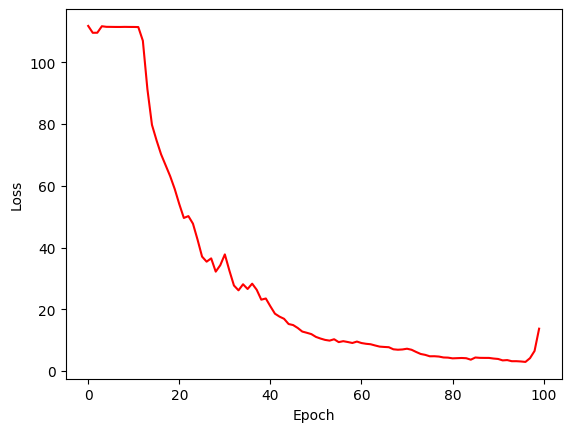

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(losshist)), losshist, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

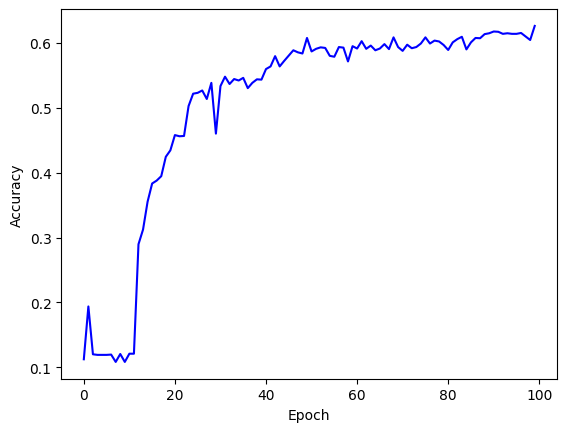

In [ ]:
plt.plot(np.arange(len(acchist)), acchist , 'b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show

### 結果の考察

もう少し詳細にみてみよう

どの記事をどのように判定したかを表にする

In [ ]:
rescat = category_tensor.cpu().numpy().copy()
respreds = preds.cpu().squeeze().numpy().copy()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rescat, respreds)
cm

array([[160,   7,   2,   7,  29,  11,  12,   5,  25],
       [  4,  96,   9,   0,  21,  15,   1,   7,   4],
       [  2,   0, 149,  34,  17,  31,   0,  27,   4],
       [  1,   3,  33, 134,  18,  28,   1,  15,  10],
       [  9,  26,   9,   3, 143,  47,   3,  19,  13],
       [  2,   9,  12,   9,  39, 160,   1,  16,  15],
       [ 21,   6,   1,   1,   8,   0, 223,   0,   9],
       [  1,  12,  17,   3,  24,  61,   0, 112,   6],
       [ 13,   2,   1,   3,  14,   7,   1,   2, 208]])

可視化する

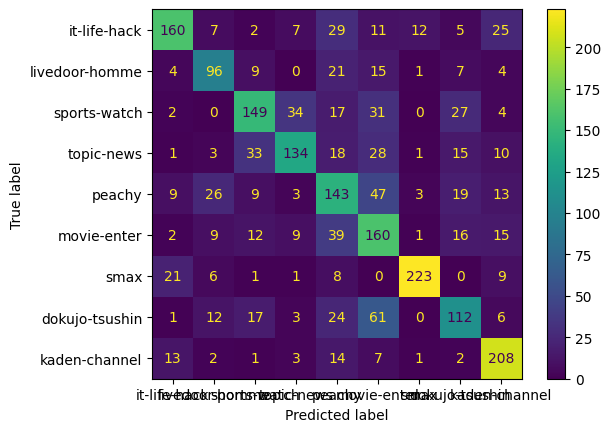

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp =ConfusionMatrixDisplay(confusion_matrix=cm,
  display_labels=categories)
disp.plot()
plt.show()

正答率が高そうなのはsmax、間違いが多いのはmovie-enterで、kaden-channelと間違える様子(なぜ？)
- 両方に頻発する単語(例えばテレビなど)で判定しているとすると可能性があると考えられる

# GRU

## GRUの構造

GRU(Gated Recurrent Unit: ゲート付き回帰型ユニット)は2014年に提案された機構であり、以下のような特徴をもつ

- LSTMに比してシンプルな構造で計算量が少ない
- 記憶セルと出力ゲートが存在しない
  - 内部状態数はGRUの方が出力ゲートがない分少ない
- 入力ゲートと忘却ゲート統合し更新ゲート(Update gate)を構成する
- 値をゼロにリセットするリセットゲート(Reset gate)が備わる

多くのタスクで LSTM と GRU は同程度の性能と報告されるが、長期依存の扱いや表現力の観点から LSTM を好む研究もある

<img src="http://class.west.sd.keio.ac.jp/dataai/text/gru.png" width=500>

図において、$\oplus$は要素同士の和、$(1-)$は1から引く演算、$\otimes$は要素同士の積、$\sigma$はシグモイド関数を表す

リセットゲート
- 新しい記憶を構成するためにどの程度過去の情報を利用するのかを決定するパラメタと考えることができる
- さらに、その調整には今の情報が利用される

更新ゲート

出力($Y=Y_t$)が新しい記憶($N$)と過去の情報($P=y_{t-1}$)で決定されているが、$Y=(1-\alpha)P+\alpha N$と読み取れる通り、出力を新しい記憶、過去の情報どちらに重きをおいて構成するかを与える






 ## GRUによる株価予測

先ほどはサインのグラフを扱ったが、実用性がよくわからないので、株価予測をGRUで行う
- Yahoo FinanceのWebページ情報をスクレイピングする、フリーで株価情報が取れる素晴らしいサイト

なお、次の点に注意しなければならない
 - 今回は日経平均株価を予測する
 - 銘柄ごとも取得できるが、Googleからのアクセスは流石にブロックされている様子なので、皆さんで工夫して、銘柄ごとの値を予測するようにしてみると良い
   - 日経平均株価情報もブロックされる可能性があるので注意すること
 - 実際に株価予測をして儲けるのであれば、きちんとお金を払ってAPIを用いて、ほぼリアルタイムな情報を入手し、APIで売買できるようにする必要があるであろう
 - 例えば野球やサッカーの点数を予測できるか？
   - 過去の点数履歴だけで予測するのはかなり困難であり、相手の情報や、野球なら、投手、打順、各選手の最近の成績、球場など、様々な情報を特徴量として取り込むべきであろう
   - そういう問題は別途ポアソン過程としてモデル化した方が興味深い結果が得られる
   - つまり、何をどのように解析したいかを知り、それに必要な情報をそろえるのは、AIではなく、人間であるということ
   - AIにとって都合の良い情報を上手くそろえていれば、あとはAIに任せばよい
   - その程度か？といわれるとその程度だが、データが大量にある場合は、AI利用のメリットが大きくなる

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
import time

## 株価の取得
まずは株価サイトからデータを取ってくる
- ここでは、BeautifulSoupを用いる
  - WebスクレイパーであるBeautifulSoup自体は本筋からずれるため、別途学ぶためのシートを準備する
- スクレイピングすることで、webからデータを取得できる
  - より強力には、Selenimumや、Firefox marionetteを利用することになる
  - この授業の自動採点システム、閲覧状況自動取得システムは、Firefox marionetteが利用されている
  - オンラインチケット獲得には重要なツールとなりつつある
- Yahoo Financeで取得するデータの範囲は次の項目を指定しなおす
  - なお、これは仕様ではなく、解析結果であるのでいつ変更となってもおかしくはない
  - Googleからの取得もいつブロックされてもおかしくない
  - pを順番に増やしながら次々と画面を更新してデータを取得し、つなげていく

| | |
|:--|:--|
|sy|取得開始年|
|sm|取得開始月|
|sd|取得開始日|
|ey|取得終了年|
|em|取得終了月|
|ed|取得終了日|
|p|取得頁|



In [ ]:
def getstockfromwebbs():
    page_num = 20  # 取得するページ数
    all_data = []
    for i in range(page_num):
        url = f"https://finance.yahoo.co.jp/quote/998407.O/history?from=20200101&to=20241231&timeFrame=d&page={i+1}"
        try:
            html = urllib.request.urlopen(url)
            soup = BeautifulSoup(html, "lxml")
            # テーブルの行を取得
            table = soup.find('table', class_='HistoryTable__1aNP')
            if not table:
                print(f"Page {i+1}: テーブルが見つかりません")
                continue
            rows = table.find('tbody').find_all('tr')
            for row in rows:
                # 日付を取得（th要素）
                date_th = row.find('th', class_='HistoryTable__date__1whp')
                if not date_th:
                    continue
                date = date_th.get_text().strip()
                # 価格データを取得（td要素）
                tds = row.find_all('td', class_='HistoryTable__detail__UV2e')
                if len(tds) >= 4:
                    prices = [td.get_text().strip() for td in tds[:4]]
                    all_data.append([date] + prices)
            print(f"Page {i+1}: {len(rows)}行取得")
            time.sleep(0.5)  # サーバーへの負荷軽減
        except Exception as e:
            print(f"Page {i+1}でエラー: {e}")
            continue
    # DataFrameに変換
    stock = pd.DataFrame(all_data, columns=['Date', 'Open', 'High', 'Low', 'Close'])
    # カンマを削除
    for col in ['Open', 'High', 'Low', 'Close']:
        stock[col] = stock[col].str.replace(',', '')
    # 日付の変換
    stock['Date'] = pd.to_datetime(stock['Date'], format="%Y年%m月%d日", errors='coerce')
    # 無効な行を削除
    stock = stock.dropna(subset=['Date'])
    # 日付でソート（古い順）
    stock = stock.sort_values('Date').reset_index(drop=True)
    return stock

この関数の実行を確認する場合は、次のコードセルを作成して実行するとよい

In [ ]:
stockbs = getstockfromwebbs()
stockbs

Page 1: 20行取得
Page 2: 20行取得
Page 3: 20行取得
Page 4: 20行取得
Page 5: 20行取得
Page 6: 20行取得
Page 7: 20行取得
Page 8: 20行取得
Page 9: 20行取得
Page 10: 20行取得
Page 11: 20行取得
Page 12: 20行取得
Page 13: 20行取得
Page 14: 20行取得
Page 15: 20行取得
Page 16: 20行取得
Page 17: 20行取得
Page 18: 20行取得
Page 19: 20行取得
Page 20: 20行取得


,Date,Open,High,Low,Close
0,2023-05-19,30847.36,30924.57,30679.16,30808.35
1,2023-05-22,30735.71,31086.82,30689.27,31086.82
2,2023-05-23,31245.72,31352.53,30828.73,30957.77
3,2023-05-24,30728.69,30856.92,30566.83,30682.68
4,2023-05-25,30599.27,30889.98,30558.14,30801.13
...,...,...,...,...,...
395,2024-12-24,39210.23,39245.75,38995.76,39036.85
396,2024-12-25,39168.52,39180.59,38927.16,39130.43
397,2024-12-26,39129.31,39592.28,39110.92,39568.06
398,2024-12-27,39672.15,40398.23,39669.39,40281.16


もし、上記が失敗するようなことがあれば、次の専用ライブラリ yfinanceを用いるとよい
- yfinanceでは、直接銘柄指定も可能である
- ただし、いつまで利用できるかは不明である

In [ ]:
!pip install --quiet yfinance

In [ ]:
import os
import time
import datetime as dt
import yfinance as yf
def getstockfromwebyf():
  # 銘柄コード入力（6501は日立製作所です。）
  ticker_symbol = "6501"
  ticker_symbol_dr = ticker_symbol + ".T"
  # 2022-01-01以降の株価取得
  start = dt.datetime.strptime('2023-01-01', '%Y-%m-%d').date()
  end = dt.datetime.strptime('2023-12-31', '%Y-%m-%d').date()
  try:
    df = yf.download(ticker_symbol_dr, start=start, end=end)
  except Exception as e:
    print(f"An error occurred with yfinance: {e}")
  # DataFrameが正常に取得できた場合、後続の処理を行う
  if df is not None:
    # 2列目に銘柄コード追加
    df.insert(0, "Code", ticker_symbol, allow_duplicates=False)
    # CSV保存（Google Colabに適した方法で保存）
    save_path = f'y_stock_data_{ticker_symbol}.csv'
    df.to_csv(save_path)
    print(f"Data saved to {save_path}")
    return df
  else:
    print("Data could not be fetched.")

実際に実行して結果を確認する

In [ ]:
stockyf = getstockfromwebyf()
stockyf

/tmp/ipython-input-160487716.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_symbol_dr, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Data saved to y_stock_data_6501.csv


Price,Code,Close,High,Low,Open,Volume
Ticker,,6501.T,6501.T,6501.T,6501.T,6501.T
Date,,,,,,
2023-01-04,6501,1255.916260,1259.748778,1206.285102,1218.165932,23071500
2023-01-05,6501,1241.927368,1251.700359,1233.304203,1250.742229,15463500
2023-01-06,6501,1256.299316,1260.898385,1232.729355,1237.903277,10706000
2023-01-10,6501,1248.826050,1276.420110,1242.885577,1275.461980,14297500
2023-01-11,6501,1258.024170,1267.988741,1248.826149,1249.209424,10481500
...,...,...,...,...,...,...
2023-12-25,6501,1965.839111,1977.552155,1960.958677,1967.791285,3410500
2023-12-26,6501,1959.006592,1968.767462,1951.588354,1963.887027,5794500


最後に、どうしても情報が取得できなかった場合、次の方法で各自取得して、次の関数を実行するとよい

手動でyahooファイナンスなどを利用して個別株価データを入手し、CSVデータをダウンロードする
- これを、ファイル名をstockdata.csvに変更する
- 左のフォルダメニューを開き、stockdata.csvをドラッグしてファイルをコラボラトリに入れる
- 次の関数は、stockdata.csvを読んで解析する

In [ ]:
import codecs
def getstockdata():
  path = 'stockdata.csv'
  with codecs.open(path, "r", "Shift-JIS", "ignore") as f:
    stock = pd.read_table(f, delimiter=",", header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Total', 'Adjustment'], index_col='Date', parse_dates=True)
    stock = stock.drop(stock.index[[0,1]])
  return stock

In [ ]:
import os
if not os.path.exists('stockdata.csv'):
  !wget "https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw" -O stockdata.csv

--2025-12-07 07:04:27--  https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw
Resolving drive.google.com (drive.google.com)... 142.251.2.113, 142.251.2.100, 142.251.2.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw&export=download [following]
--2025-12-07 07:04:28--  https://drive.usercontent.google.com/download?id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8808 (8.6K) [application/octet-stream]
Saving to: ‘stockdata.csv’

stockdata.csv       100%[===================>]   8.60K  --.-KB/s    in

In [ ]:
stockread = getstockdata()
stockread

/tmp/ipython-input-677479694.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock = pd.read_table(f, delimiter=",", header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Total', 'Adjustment'], index_col='Date', parse_dates=True)


,Open,High,Low,Close,Total,Adjustment
Date,,,,,,
2020-01-06,2770,2776,2690,2690,462800,2690
2020-01-07,2725,2751,2709,2750,240700,2750
2020-01-08,2714,2727,2692,2711,275800,2711
2020-01-09,2734,2756,2732,2749,213800,2749
2020-01-10,2765,2773,2753,2755,175400,2755
...,...,...,...,...,...,...
2020-08-20,2274,2285,2262,2276,88000,2276
2020-08-21,2270,2291,2255,2255,86600,2255
2020-08-24,2255,2255,2228,2228,126100,2228


いつもの通りの前準備だが、新たに`torch.manual_seed`が呼び出されている
- これは、実験の再現性を高めるため、同じ乱数を生成させる
- 研究用途などで利用されるテクニック
  - False=0で同一系列の乱数を生成し、True=1で一般的な乱数となる


In [ ]:
import numpy as np
import pandas as pd
import codecs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(1)

次のコードで、3つの方法で取得した株価データのどのデータを利用するかを選択する

In [ ]:
df = stockbs # yahooファイナンスの日経平均株価をbeautiful soopで取得
#df = stockyf # 専用ライブラリを用いて銘柄指定で取得
#df = stockread # 別途保存したファイルから取得
df

,Date,Open,High,Low,Close
0,2023-05-19,30847.36,30924.57,30679.16,30808.35
1,2023-05-22,30735.71,31086.82,30689.27,31086.82
2,2023-05-23,31245.72,31352.53,30828.73,30957.77
3,2023-05-24,30728.69,30856.92,30566.83,30682.68
4,2023-05-25,30599.27,30889.98,30558.14,30801.13
...,...,...,...,...,...
395,2024-12-24,39210.23,39245.75,38995.76,39036.85
396,2024-12-25,39168.52,39180.59,38927.16,39130.43
397,2024-12-26,39129.31,39592.28,39110.92,39568.06
398,2024-12-27,39672.15,40398.23,39669.39,40281.16


学習用データを作成する
- pandasからnumpyに変換するにはvaluesを使う
- 直接金額を扱ってもよいが、株価予測の場合、銘柄間の変動予測や銘柄間の相関性も扱うことが多いことから、金額ではなく割合で評価した方が将来的に応用できやすいであろう
  - データ全体から最大値、最低値を取得し、その割合をもって学習させる
  - この方法では、突発的な価格上昇や下落には対応できない
  - 普通にmin, max標準化を行う
    - 平均0・分散1にスケーリングすると、外れ値が大きな値となり、外れ値に引きずられた結果となる


In [ ]:
#訓練データとテストデータに分割
test_size = 0.3
sp = df['Close'].astype(float).values # pandasからnumpyへ変換
total_len = len(sp)
test_len = int(len(sp)*test_size)
train_len = total_len - test_len
print("total_len:", total_len, " train_len:", train_len, "test_len:", test_len)
train = sp[0:train_len]
test = sp[train_len:total_len]
x_max, x_min = max(sp), min(sp)
train_norm = (train - x_min) / (x_max - x_min)
test_norm = (test - x_min) / (x_max - x_min)

total_len: 400  train_len: 280 test_len: 120


データを分割する
- DataLoaderに食べさせるデータを作る
- n_timeのブロックを入力とし、次のデータを教師とするデータを作成する
- 訓練用とテスト用の両方作成する

In [ ]:
#時系列データに分割
n_time = 6
x_train, y_train, x_test, y_test= [], [], [], []
for i in range(train_len-n_time):
  x_train.append(train_norm[i:i+n_time].reshape(-1,1))
  y_train.append(train_norm[i+n_time])
for i in range(test_len-n_time):
  x_test.append(test_norm[i:i+n_time])
  y_test.append(test_norm[i+n_time])

作成したデータをTensorDatasetとしてDataLoaderに渡す
- この時torchテンソルに変換する必要がある

In [ ]:
epochs = 50
batch_size = 32
train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換
train_correct_data = torch.tensor(y_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(train_input_data, train_correct_data)  # trainデータセットの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_input_data = torch.tensor(x_test, dtype=torch.float)  # テンソルに変換
test_correct_data = torch.tensor(y_test, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(test_input_data, test_correct_data)  # testデータセットの作成
test_loader = DataLoader(test_dataset, batch_size=len(x_test))

device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/tmp/ipython-input-2263362525.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換


GRUを指定する

RNN, LSTM, GRUは、基本的に名前だけ変えればよいのがわかるであろう

In [ ]:
class GRUN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(GRUN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    # DataParallel や断片化した GPU メモリ下での cudnn エラーを防ぐ
    self.gru.flatten_parameters()  # :contentReference[oaicite:0]{index=0}

    # x: (batch, seq_len, input_size)
    output, hidden = self.gru(x, hidden)
    y = self.fc(output[:, -1, :])  # 最終時刻だけを取り出し
    return y, hidden
model = GRUN(input_size=1, hidden_size=100, output_size=1).to(device)
print(model)

GRUN(
  (gru): GRU(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


損失関数に平均二乗誤差、最適化にはADAMを利用する
- これらも定番

In [ ]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
record_loss_train = []
for epoch in range(epochs):
    model.train()

    # エポック開始時に隠れ状態をゼロ初期化
    # train_loader.batch_size が同じなら一度だけ作ればOK
    h = torch.zeros(model.num_layers,
                    train_loader.batch_size,
                    model.hidden_size,
                    device=device)
    hidden = h  # GRU は (h, ) のタプル形式ですが、1層ならテンソルひとつでも可

    epoch_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        bs = x.size(0)
        # 最後のバッチなどでサイズが変わる場合は再初期化
        if bs != hidden.size(1):
            hidden = torch.zeros(model.num_layers, bs,
                                 model.hidden_size,
                                 device=device)  # :contentReference[oaicite:1]{index=1}

        x = x.to(device)
        t = t.view(bs, 1).to(device)

        # 順伝播＋隠れ状態更新
        y, hidden = model(x, hidden)

        # 過去バッチまで逆伝播しないように切り離す
        hidden = hidden.detach()  # トランケーテッド BPTT :contentReference[oaicite:2]{index=2}

        # 損失・逆伝播・最適化
        loss = loss_func(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (j + 1)
    record_loss_train.append(avg_loss)
    print(f"epoch {epoch:3d} | loss {avg_loss:.6f}")

epoch   0 | loss 0.058537
epoch   1 | loss 0.175208
epoch   2 | loss 0.049576
epoch   3 | loss 0.012807
epoch   4 | loss 0.008390
epoch   5 | loss 0.011707
epoch   6 | loss 0.019315
epoch   7 | loss 0.007516
epoch   8 | loss 0.004605
epoch   9 | loss 0.004699
epoch  10 | loss 0.004422
epoch  11 | loss 0.006647
epoch  12 | loss 0.005982
epoch  13 | loss 0.008127
epoch  14 | loss 0.006533
epoch  15 | loss 0.008613
epoch  16 | loss 0.005979
epoch  17 | loss 0.007124
epoch  18 | loss 0.004762
epoch  19 | loss 0.005225
epoch  20 | loss 0.003728
epoch  21 | loss 0.003973
epoch  22 | loss 0.003109
epoch  23 | loss 0.003330
epoch  24 | loss 0.002816
epoch  25 | loss 0.003073
epoch  26 | loss 0.002745
epoch  27 | loss 0.003067
epoch  28 | loss 0.002838
epoch  29 | loss 0.003255
epoch  30 | loss 0.003075
epoch  31 | loss 0.003627
epoch  32 | loss 0.003449
epoch  33 | loss 0.004183
epoch  34 | loss 0.003945
epoch  35 | loss 0.004900
epoch  36 | loss 0.004508
epoch  37 | loss 0.005684
epoch  38 | 

学習した結果を用いて、実際に推定を行う
- 本来は、違う年度で行うのが正しいであろうが、Fasion-MNISTも同様に、このあたりは授業で扱い方を学ぶという観点から、若干おおらかになっている

途中、`in_true = list(sp_norm.reshape(-1).astype(np.float32))`といった記述があるが、極めて重要な記述である
- CPUはFloat64つまり、64bit CPUを搭載したパソコン(64bit PCなどともいうが)が普通に流通しており、このCPUで表現できるデータとして保存している
- GPUはFloat32つまり、32bitで構成されている
  - これは、画像では32bitあれば、24bitフルカラー+$\alpha$が表現できるため十分である
  - 機械学習用途でも、ビット幅は学習精度にほとんど影響を与えず、Float32(FP32)の他、Float16(FP16)もよく利用されている
    - 中にはINT8, INT4, INT2といった特殊な表現も研究されている
  - 以上のように、変数の表現を簡略化して計算性能を挙げているという見方もできる

つまり、GPUではFloat32を使ってデータを扱っている
- このGPUにCPUが扱えるFloat64をそのまま入れるとエラーになる
  - 実際に`.astype(np.float32))`を削除して試してみると良い
  - なぞなRUNTIME ERRORとなり、原因究明すらも難しい状態にるかもしれないが、それでも型を調べて何が違うのかを追いかけると、簡単に誤りにたどり着くことができる
    - きちんとFloat32かFloat64かは区別できるようになっている

したがって、Float64をそのままGPUに入れるとエラーになる
- つまり、GPUを使う前提であれば、FP32にするのが得策である
- CPUは汎用性をうたっており、この点はどうでもよく、FP16、FP32、FP64すべて問題なく動作できる


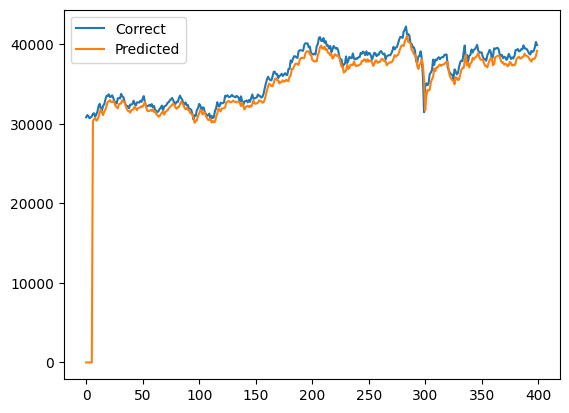

In [ ]:
sp_norm = sp/x_max
in_true = list(sp_norm.reshape(-1).astype(np.float32)) # ここの意味を理解する
pred = []
model.eval()
for i in range(n_time):
  pred.append(0) # 最初は予測できないので0を加える
hidden = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
with torch.no_grad():
    for i in range(len(sp)-n_time):
      x = torch.tensor(in_true[i:i+n_time])  # 直近の時系列を取り出す
      x = x.reshape(1, -1, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      y = model(x.to(device), hidden)
      pred.append(y[0].item())  # 予測結果をpredictedに追加する
plt.plot(range(len(sp)), sp, label="Correct")
pred = np.array(pred)
pred = pred * x_max
plt.plot(range(len(pred)), pred, label="Predicted")
plt.legend()
plt.show()

流石に知っているデータは、当然のごとく再現する

114


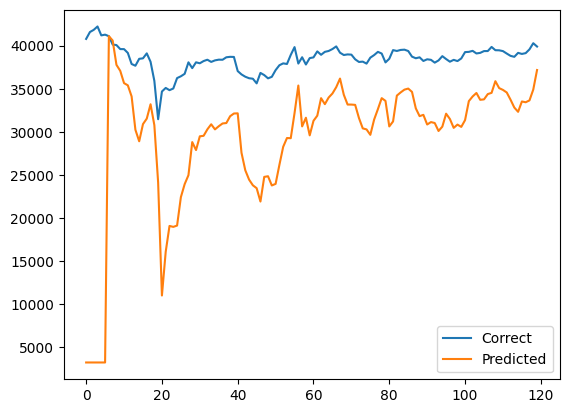

In [ ]:
test_norm = test/x_max
in_true = list(test_norm.reshape(-1).astype(np.float32)) # ここの意味を理解する
pred = []
model.eval()
for i in range(n_time):
  pred.append(0) # 最初は予測できないので0を加える
with torch.no_grad():
  for j, (x, t) in enumerate(test_loader):
    x = x.reshape(len(x),6,1)
    batch_size = x.size(0)
    hidden = torch.zeros(model.num_layers, batch_size, model.hidden_size, device=device)
    x, t = x.to(device), t.reshape(-1,1).to(device)
    y, _ = model(x, hidden)
    y = y.to('cpu').detach().ravel().numpy().copy().tolist()
    print(len(y))
    pred.extend(y)  # 予測結果をpredictedに追加する
plt.plot(range(len(test)), test, label="Correct")
pred = np.array(pred)
pred = pred * x_max + test[n_time]-pred[n_time]*x_max
plt.plot(range(len(pred)), pred, label="Predicted")
plt.legend()
plt.show()

まぁ、そんなに当たるもんではないが、良い線か？
- 初期値はチートしている

なお、
- 翌日予測が値を下げるようであれば、今のうちに売る
- 翌日予測が値を上げるようであれば、今のうちに買う

という操作の他、
- その時の手数料も勘案して、利益が上がると確定できるときに売る
- 予測毎の確度を得て、その確度に応じて売る量を決める
- 経済的情勢などを特徴量に加える

などの追加ができるであろう

# 課題1(RNN)

上記株価予想を、さらにRNNおよびLSTMを用いて評価し、3つの結果を比較しなさい
- 結果は比較するだけでよいが、考察があるとなおよい
- 但し「定量的な評価」で比較すること

# 課題2(GRU)

- 上記記事分類を、GRNを用いて評価して比較しなさい
- 分類において分類において誤りが最も多かった2つの記事について、その2つの記事だけにデータセットを絞って学習させてなさい
  - 精度は向上したであろうか
  - 例えば、データセットに含まれる単語に注目して、該当する文章をデータセットから削除、もしくは文章を修正するなどすることで、混乱した理由を探ってみよう

# 課題3(RNNの効果)

一般的な全結合網を用いたNNとGRUを用いて、以下の各命題についてシンプルに評価しなさい
- パラメータ数を揃える、学習時間を揃えるなど、なにかしらの条件を揃えて比較評価できるようにすること
  - 最低でもGRUに対する入力のウィンドウサイズwとNNの入力サイズsを揃えること
- 結果を予測したうえで、実際に比較評価し、簡単に考察しなさい
- なお、予測と実際の評価が異なっても、採点に影響せず、コードを含む記述内容が採点の対象となる点に注意しなさい

(1) 一様乱数や円周率など周期性のない値で構成した数列を推定する  
(2) 循環小数など周期性のある値を推定する  
(3) 異なる周期性のある2つの数列をm:nで連続して結合した数列を推定する  
(4) 異なる周期性のある2つの数列を足し合わせた数列を推定する
(5) wもしくはsについて、それ以上の周期をもつ入力に対する予測精度について考察しなさい

# 課題4(stateful と stateless)

テキスト中のモデルについて、statefulとstatelessを入れ替えて実装し、その効果を確認しなさい
- Fashion-MNIST+statefulにする
- 記事分類モデルをstatefulにする
- 株価予想をstetelessにする

なお、次の例でStatefulとStatelessの差を理解できる

ただし、これは明確にするためにRNNを利用している

- Stateless は毎ウィンドウごとに「隠れ状態・セル状態」をゼロにリセットするので、そのウィンドウ内では足し込み動作を行うが、累積できるのはウィンドウ長まで
- Stateful はウィンドウをまたいでも状態を保持するので、ウィンドウを超えてさらに先まで正しく累積しつづける

という違いがある

もし「シーケンス全体を1つのウィンドウ（window_size = total_len）で処理する」なら、stateless でも stateful でも違いは出ないが、実際は、長いシーケンスをいくつかの小さなチャンクに分けて学習（Truncated BPTT）するため、stateless はチャンク境界でリセットされ、長距離依存を学べず、結果的に stateful が有利になる

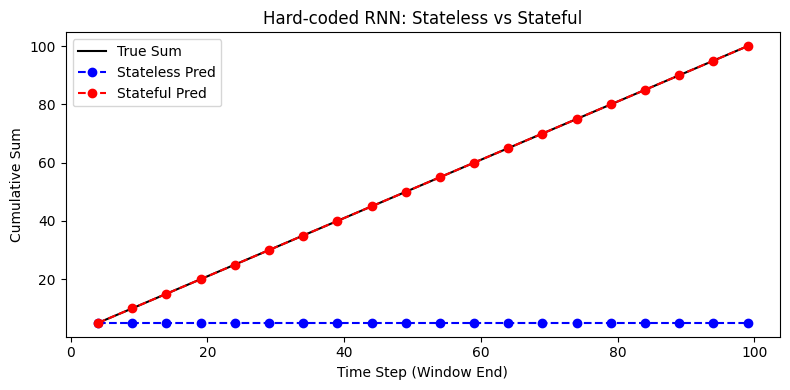

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# === Hard-coded RNN Demo: Stateless vs Stateful Accumulation ===
# We use a simple RNN with identity weights to compute a running sum of inputs.
# Input is a sequence of ones; stateless resets hidden each window -> constant sum per window.
# Stateful carries hidden across windows -> true cumulative sum.

total_len = 100
w_size = 5  # window size (truncated BPTT)
seq = np.ones(total_len, dtype=np.float32)
true_cumsum = np.arange(1, total_len+1, dtype=np.float32)

# Prepare windows: (window_input, true_sum_after_window)
windows = []
for i in range(0, total_len, w_size):
    # window inputs
    x_win = seq[i:i+w_size]
    # true cumulative sum at end of window
    true_sum = true_cumsum[min(i + w_size - 1, total_len-1)]
    windows.append((x_win, true_sum))

# Define RNN cell with ReLU nonlinearity
rnn = nn.RNN(input_size=1, hidden_size=1, nonlinearity='relu', batch_first=True)
# Manually set weights to identity-like behavior
torch.manual_seed(0)
with torch.no_grad():
    rnn.weight_ih_l0.fill_(1.0)
    rnn.weight_hh_l0.fill_(1.0)
    rnn.bias_ih_l0.fill_(0.0)
    rnn.bias_hh_l0.fill_(0.0)

# Containers for predictions
stateless_preds = []
stateful_preds = []

# Initialize stateful hidden once
h_stateful = torch.zeros(1, 1, 1)

# Run through windows
for x_win, _ in windows:
    # prepare tensor shape (1, w_size, 1)
    x_t = torch.tensor(x_win, dtype=torch.float32).view(1, w_size, 1)

    # Stateless: reset hidden
    out_s, _ = rnn(x_t, torch.zeros_like(h_stateful))
    stateless_preds.append(out_s[0, -1, 0].item())

    # Stateful: carry hidden
    out_f, h_stateful = rnn(x_t, h_stateful)
    stateful_preds.append(out_f[0, -1, 0].item())

# True values at window ends
true_vals = [t for _, t in windows]
window_indices = np.arange(len(windows)) * w_size + (w_size - 1)

# Plot results
plt.figure(figsize=(8,4))
plt.plot(window_indices, true_vals, 'k-', label='True Sum')
plt.plot(window_indices, stateless_preds, 'b--o', label='Stateless Pred')
plt.plot(window_indices, stateful_preds,  'r--o', label='Stateful Pred')
plt.xlabel('Time Step (Window End)')
plt.ylabel('Cumulative Sum')
plt.title('Hard-coded RNN: Stateless vs Stateful')
plt.legend()
plt.tight_layout()
plt.show()

# Interoperable Learningしてみよう

RNNはその問題点からほぼ利用されておらず、LSTMも計算コストの大きさから近年は敬遠の傾向にあり、Transformerの基本であるPositional EncoderとAttentionにより構築する傾向にある

近年では、RWKVと呼ばれる、Attention の計算を再帰形式で近似した RNN系のモデルも提案されている

別テキストでAttention、Transformer、さらにRWKVについて学ぶことができる